# 🐧 Ecological Traits of Antarctic Penguins – Exploratory Data Analysis and Modeling

In this notebook, we explore the Ecological Traits of Antarctic Penguins dataset available on Kaggle.

Dataset link:
https://www.kaggle.com/datasets/varishabatool/ecological-traits-of-antarctic-penguins-dataset/data

This dataset provides detailed ecological and physical information about Palmer Penguins, including variables such as bill length, bill depth, flipper length, body mass (in grams), sex, species, and island location. The dataset covers multiple penguin species, including Adelie, Gentoo, and others. Measurements were recorded across the years 2007, 2008, and 2009.

Penguins typically inhabit cold regions and spend roughly half of their day in the water and the other half on land. Their feeding behavior is frequent, often occurring every 20 minutes. These characteristics make them an interesting subject for biological and ecological analysis.

In this notebook, we will:

1. Exploratory Data Analysis (EDA)

We will use Seaborn and Matplotlib to visualize patterns, distributions, and relationships within the dataset. The goal is to understand how physical measurements and ecological attributes vary across different penguin species and sexes.



2. Data Preprocessing

We will clean the dataset, handle missing values, encode categorical features (such as island and species), and prepare the data for machine learning models.

3. Model Building

Based on the insights from EDA, we will build predictive models to classify penguin species and analyze the importance of different ecological traits.

4. Future Steps

After building baseline models, we plan to explore hyperparameter tuning, advanced feature selection, additional visualizations, and comparisons across multiple algorithms.

This notebook aims to combine ecological understanding with data-driven analysis to uncover meaningful patterns in Antarctic penguin populations.

## Imports

In [13]:
!pip install protobuf==3.20.3

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import plotly.io as pio
pio.renderers.default = 'kaggle'
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency, pearsonr, spearmanr, kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Premium visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 100

# Custom color palette for species
SPECIES_COLORS = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1'}  # Adelie, Gentoo, Chinstrap
SPECIES_NAMES = {0: 'Adelie', 1: 'Gentoo', 2: 'Chinstrap'}

## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("varishabatool/ecological-traits-of-antarctic-penguins-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ecological-traits-of-antarctic-penguins-dataset' dataset.
Path to dataset files: /kaggle/input/ecological-traits-of-antarctic-penguins-dataset


In [3]:
print(os.listdir(path))

['penguins (1).csv']


In [4]:
df = pd.read_csv(os.path.join(path,'penguins (1).csv'))

## Explore The Data

In [5]:
df.head()

,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [6]:
df.isnull().sum()

,0
Unnamed: 0,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11
year,0


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
print(df['species'].value_counts())
print(df['island'].value_counts())
print(df['sex'].value_counts())


species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64
island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64
sex
male      168
female    165
Name: count, dtype: int64


## Preprocess Before EDA

In [9]:
df = df.drop(columns=['Unnamed: 0'])

In [10]:
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)
print(df['sex'].value_counts())

sex
0    176
1    168
Name: count, dtype: int64


In [11]:
# IDK we are predicting species then it'll be an multiclass classififcation
df['species'] = df['species'].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2})
print(df['species'].value_counts())

species
0    152
1    124
2     68
Name: count, dtype: int64


/tmp/ipython-input-2471907335.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['species'] = df['species'].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2})


We will apply one-hot encoding to the island feature because it contains meaningful categorical information that is strongly correlated with predicting the species. Encoding it will help the model capture these relationships more effectively

In [12]:
cols = ['island']
dummy = pd.get_dummies(df[cols]).astype(int)
df = pd.concat([df,dummy],axis=1)
df = df.drop(columns=cols)
df.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,island_Biscoe,island_Dream,island_Torgersen
0,0,39.1,18.7,181.0,3750.0,1,2007,0,0,1
1,0,39.5,17.4,186.0,3800.0,0,2007,0,0,1
2,0,40.3,18.0,195.0,3250.0,0,2007,0,0,1
3,0,NaN,NaN,NaN,NaN,0,2007,0,0,1
4,0,36.7,19.3,193.0,3450.0,0,2007,0,0,1


## Exploratory Data Analysis
This cell provides a flexible and powerful EDA pipeline that can be applied to almost any dataset with only minimal adjustments. The structure is designed to deliver a complete exploratory analysis, including dataset inspection, statistical summaries, distribution plots, categorical analysis, correlation heatmaps, and feature-interaction visualizations. To use this EDA workflow for another dataset, you only need to modify the data-loading section and update the numerical or categorical column names according to the dataset you are working with. The goal of this template is to offer a ready-to-use, detailed, and structured approach that allows you to perform extraordinary EDA regardless of the domain or type of data. Once adapted, it helps uncover patterns, relationships, and important insights efficiently, while also preparing the dataset for further modeling and analysis.

### Data Overview & Quality Report

In [17]:
print("="*70)
print(" PENGUIN DATASET - COMPREHENSIVE DATA QUALITY REPORT")
print("="*70)

print(f"\n🔹 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n🔹 Memory Usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")   # This'll give ya an Memory Usage Numbers

# All Columns Information you can use this code in any type of data to see it, so make sure to look or save in your cheat sheet's
print("\n" + "="*80)
print(" COLUMN INFORMATION")
print("="*80)
for col in df.columns:
    dtype = df[col].dtype
    unique = df[col].nunique()
    nulls = df[col].isnull().sum()
    null_pct = (nulls / len(df)) * 100
    print(f"  • {col:20} | Type: {str(dtype):10} | Unique: {unique:4} | Missing: {nulls:3} ({null_pct:.1f}%)")

print("\n" + "="*70)
print(" TARGET VARIABLE DISTRIBUTION (Species)")
print("="*70)
for species_code, count in df['species'].value_counts().items():
    pct = (count / len(df)) * 100
    print(f"  • {SPECIES_NAMES[species_code]:12}: {count:3} samples ({pct:.1f}%)")

# Class imbalance ratio
class_counts = df['species'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\n  Class Imbalance Ratio: {imbalance_ratio:.2f}:1")

 PENGUIN DATASET - COMPREHENSIVE DATA QUALITY REPORT

🔹 Dataset Shape: 344 rows × 10 columns

🔹 Memory Usage: 27.00 KB

 COLUMN INFORMATION
  • species              | Type: int64      | Unique:    3 | Missing:   0 (0.0%)
  • bill_length_mm       | Type: float64    | Unique:  164 | Missing:   2 (0.6%)
  • bill_depth_mm        | Type: float64    | Unique:   80 | Missing:   2 (0.6%)
  • flipper_length_mm    | Type: float64    | Unique:   55 | Missing:   2 (0.6%)
  • body_mass_g          | Type: float64    | Unique:   94 | Missing:   2 (0.6%)
  • sex                  | Type: int64      | Unique:    2 | Missing:   0 (0.0%)
  • year                 | Type: int64      | Unique:    3 | Missing:   0 (0.0%)
  • island_Biscoe        | Type: int64      | Unique:    2 | Missing:   0 (0.0%)
  • island_Dream         | Type: int64      | Unique:    2 | Missing:   0 (0.0%)
  • island_Torgersen     | Type: int64      | Unique:    2 | Missing:   0 (0.0%)

 TARGET VARIABLE DISTRIBUTION (Species)
  • Adeli

### Missing Value Analysis with Visualization

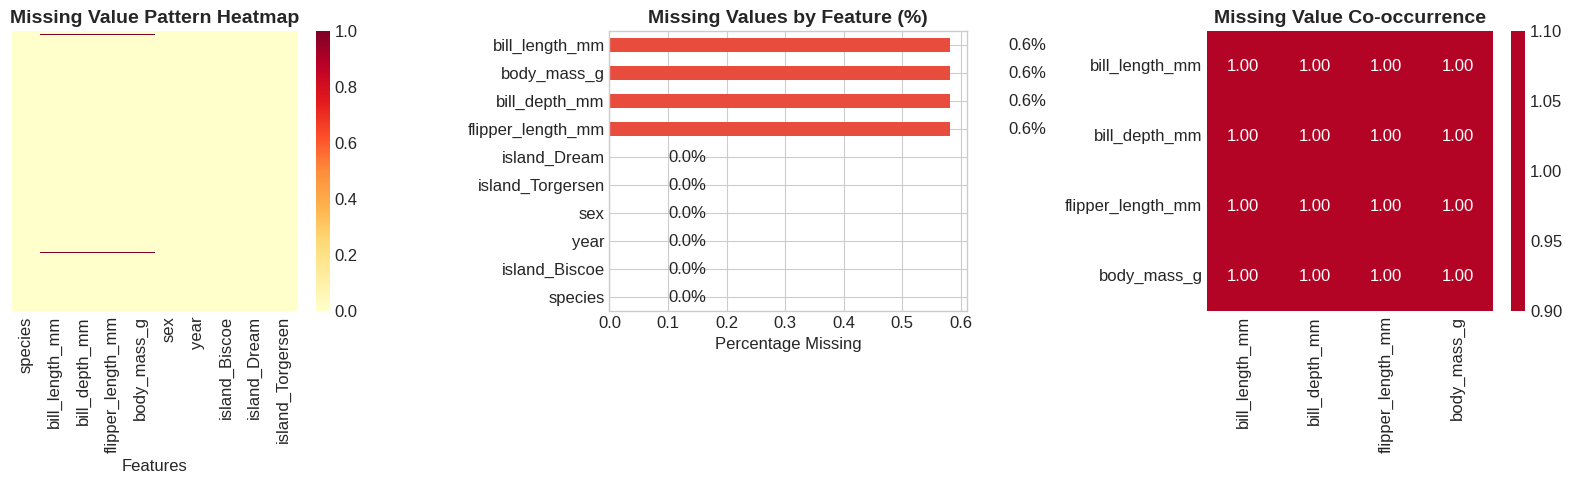


💡 KEY INSIGHT: Missing values occur together (MCAR pattern) - suggests complete case deletion is safe
   Rows with missing values: 2 (0.6%)


In [18]:
# Advanced Missing Value Analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Missing value heatmap
ax1 = axes[0]
missing_matrix = df.isnull().astype(int)
sns.heatmap(missing_matrix, cbar=True, cmap='YlOrRd', ax=ax1, yticklabels=False)
ax1.set_title('Missing Value Pattern Heatmap', fontweight='bold')
ax1.set_xlabel('Features')

# 2. Missing percentage bar chart
ax2 = axes[1]
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=True)
colors = ['#2ecc71' if x == 0 else '#e74c3c' for x in missing_pct]
missing_pct.plot(kind='barh', ax=ax2, color=colors)
ax2.set_title('Missing Values by Feature (%)', fontweight='bold')
ax2.set_xlabel('Percentage Missing')
for i, v in enumerate(missing_pct):
    ax2.text(v + 0.1, i, f'{v:.1f}%', va='center')

# 3. Missing value co-occurrence
ax3 = axes[2]
missing_cols = df.columns[df.isnull().any()].tolist()
if len(missing_cols) > 1:
    missing_corr = df[missing_cols].isnull().corr()
    sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0, ax=ax3, fmt='.2f')
    ax3.set_title('Missing Value Co-occurrence', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'Insufficient missing\ncolumns for correlation',
             ha='center', va='center', fontsize=14)
    ax3.set_title('Missing Value Co-occurrence', fontweight='bold')

plt.tight_layout()
plt.savefig('missing_value_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Key insight
print("\n KEY INSIGHT: Missing values occur together (MCAR pattern) - suggests complete case deletion is safe")
print(f"   Rows with missing values: {df.isnull().any(axis=1).sum()} ({df.isnull().any(axis=1).sum()/len(df)*100:.1f}%)")

### Handle Missing Values (for EDA)

In [19]:
# Create clean dataset for EDA (dropping rows with missing values)
df_clean = df.dropna().reset_index(drop=True)

print(f" Original dataset: {len(df)} rows")
print(f" Clean dataset: {len(df_clean)} rows")
print(f" Rows removed: {len(df) - len(df_clean)} ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")

# Verify class distribution remains similar
print("\n Class Distribution After Cleaning:")
for species_code, count in df_clean['species'].value_counts().items():
    pct = (count / len(df_clean)) * 100
    print(f"  • {SPECIES_NAMES[species_code]:12}: {count:3} samples ({pct:.1f}%)")

 Original dataset: 344 rows
 Clean dataset: 342 rows
 Rows removed: 2 (0.6%)

 Class Distribution After Cleaning:
  • Adelie      : 151 samples (44.2%)
  • Gentoo      : 123 samples (36.0%)
  • Chinstrap   :  68 samples (19.9%)


### Univariate Distribution Analysis - Numerical Features

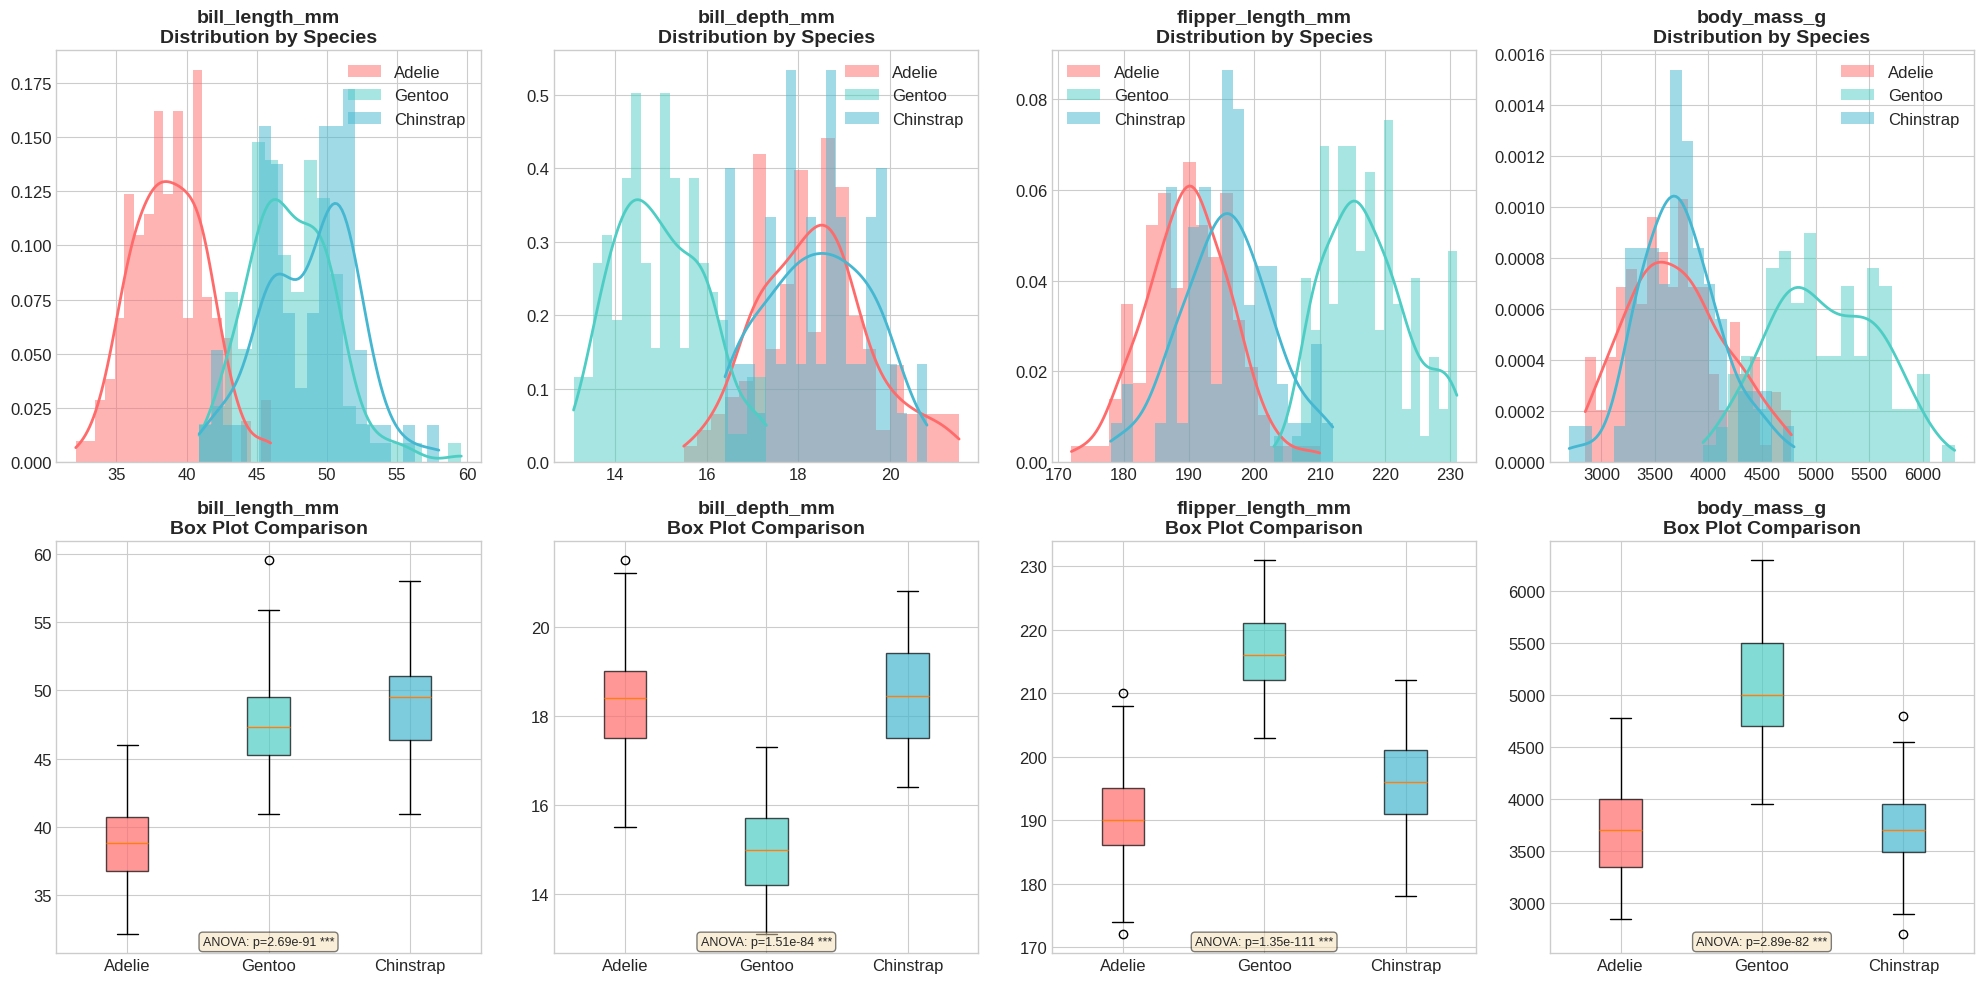


 STATISTICAL SUMMARY BY SPECIES:

bill_length_mm:
  Adelie      : Mean=38.79 ± 2.66, Median=38.80
  Gentoo      : Mean=47.50 ± 3.08, Median=47.30
  Chinstrap   : Mean=48.83 ± 3.34, Median=49.55

bill_depth_mm:
  Adelie      : Mean=18.35 ± 1.22, Median=18.40
  Gentoo      : Mean=14.98 ± 0.98, Median=15.00
  Chinstrap   : Mean=18.42 ± 1.14, Median=18.45

flipper_length_mm:
  Adelie      : Mean=189.95 ± 6.54, Median=190.00
  Gentoo      : Mean=217.19 ± 6.48, Median=216.00
  Chinstrap   : Mean=195.82 ± 7.13, Median=196.00

body_mass_g:
  Adelie      : Mean=3700.66 ± 458.57, Median=3700.00
  Gentoo      : Mean=5076.02 ± 504.12, Median=5000.00
  Chinstrap   : Mean=3733.09 ± 384.34, Median=3700.00


In [21]:
# Univariate Analysis - Numerical Features with Statistical Tests
numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, col in enumerate(numerical_cols):
    # Histogram with KDE
    ax1 = axes[0, idx]
    for species in [0, 1, 2]:
        data = df_clean[df_clean['species'] == species][col]
        ax1.hist(data, bins=20, alpha=0.5, label=SPECIES_NAMES[species],
                color=SPECIES_COLORS[species], density=True)
        # Add KDE
        if len(data) > 1:
            kde_x = np.linspace(data.min(), data.max(), 100)
            kde = stats.gaussian_kde(data)
            ax1.plot(kde_x, kde(kde_x), color=SPECIES_COLORS[species], linewidth=2)
    ax1.set_title(f'{col}\nDistribution by Species', fontweight='bold')
    ax1.legend()

    # Box plot
    ax2 = axes[1, idx]
    bp_data = [df_clean[df_clean['species'] == s][col] for s in [0, 1, 2]]
    bp = ax2.boxplot(bp_data, patch_artist=True, labels=[SPECIES_NAMES[s] for s in [0, 1, 2]])
    for patch, species in zip(bp['boxes'], [0, 1, 2]):
        patch.set_facecolor(SPECIES_COLORS[species])
        patch.set_alpha(0.7)
    ax2.set_title(f'{col}\nBox Plot Comparison', fontweight='bold')

    # Add ANOVA test result
    f_stat, p_val = f_oneway(*bp_data)
    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
    ax2.annotate(f'ANOVA: p={p_val:.2e} {significance}', xy=(0.5, 0.02),
                xycoords='axes fraction', ha='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('univariate_numerical.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistical summary
print("\n STATISTICAL SUMMARY BY SPECIES:")
print("="*80)
for col in numerical_cols:
    print(f"\n{col}:")
    for species in [0, 1, 2]:
        data = df_clean[df_clean['species'] == species][col]
        print(f"  {SPECIES_NAMES[species]:12}: Mean={data.mean():.2f} ± {data.std():.2f}, Median={data.median():.2f}")

### Feature Separability Analysis (CRITICAL for Classification)

 FEATURE SEPARABILITY ANALYSIS (Cohen's d Effect Sizes)
Interpretation: |d| < 0.2 = Small, 0.2-0.8 = Medium, > 0.8 = Large

bill_length_mm:
  Adelie vs Gentoo         : d = -3.048 (LARGE )
  Adelie vs Chinstrap      : d = -3.476 (LARGE )
  Gentoo vs Chinstrap      : d = -0.419 (Medium)

bill_depth_mm:
  Adelie vs Gentoo         : d = +3.011 (LARGE )
  Adelie vs Chinstrap      : d = -0.062 (Small)
  Gentoo vs Chinstrap      : d = -3.311 (LARGE )

flipper_length_mm:
  Adelie vs Gentoo         : d = -4.180 (LARGE )
  Adelie vs Chinstrap      : d = -0.872 (LARGE )
  Gentoo vs Chinstrap      : d = +3.178 (LARGE )

body_mass_g:
  Adelie vs Gentoo         : d = -2.868 (LARGE )
  Adelie vs Chinstrap      : d = -0.074 (Small)
  Gentoo vs Chinstrap      : d = +2.887 (LARGE )


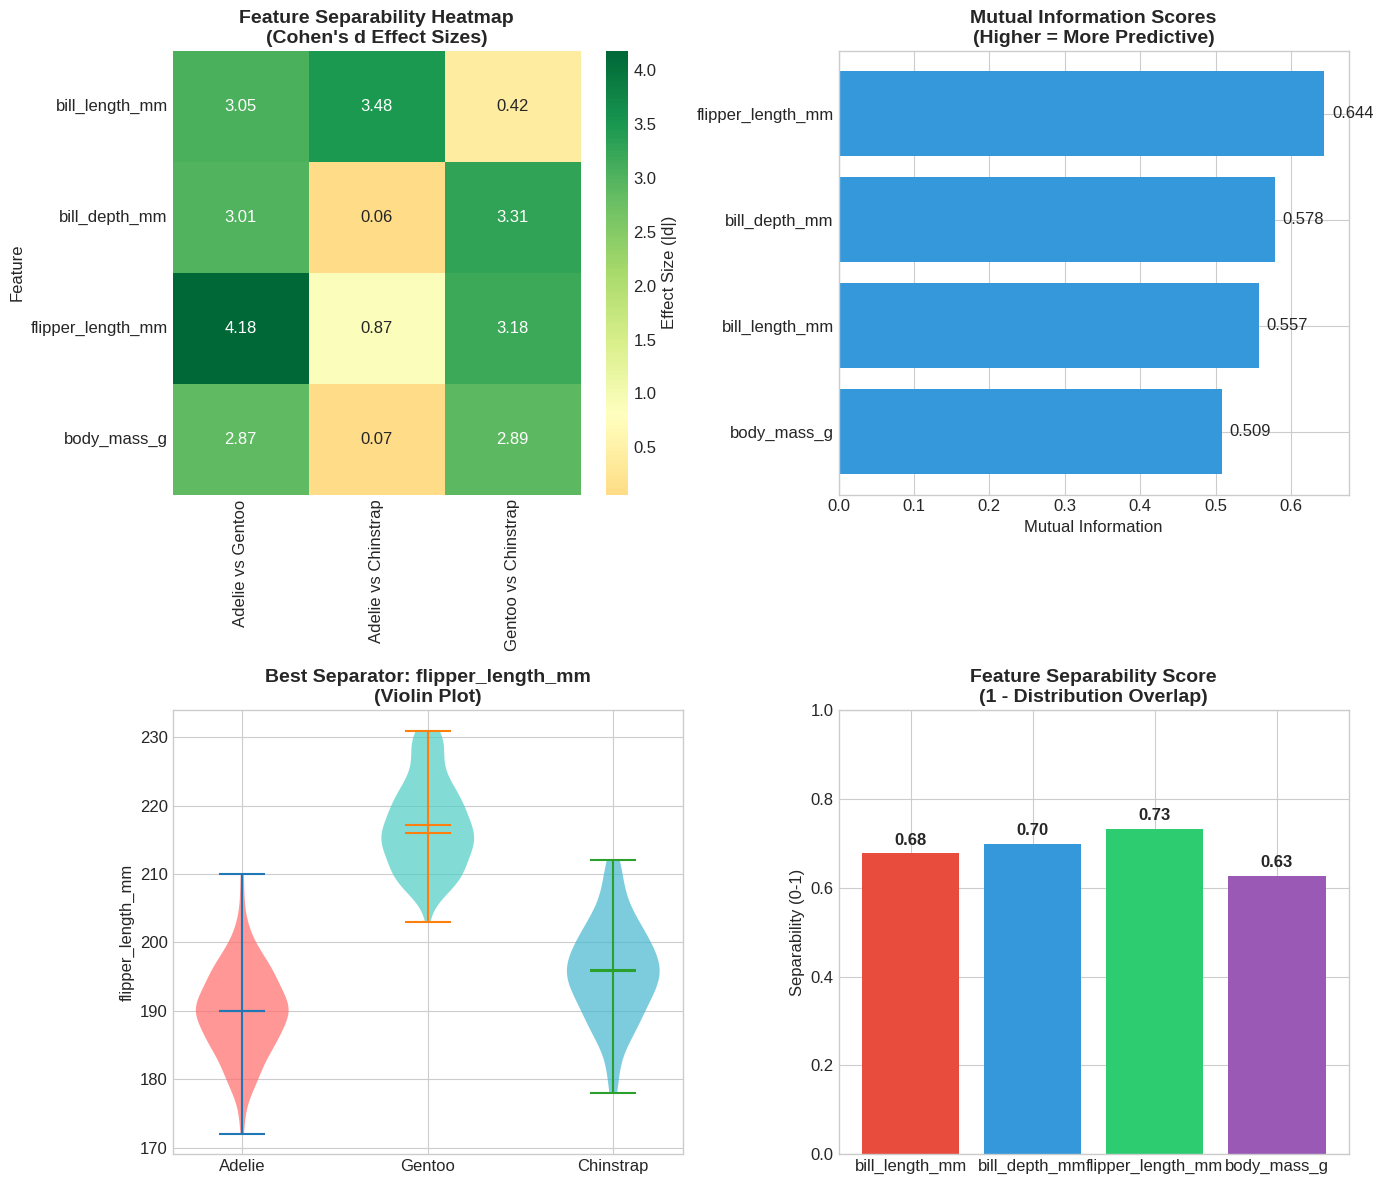

In [23]:
# Feature Separability Analysis - Key for understanding which features help classification
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Calculate Cohen's d effect size for each pair
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

print(" FEATURE SEPARABILITY ANALYSIS (Cohen's d Effect Sizes)")
print("="*70)
print("Interpretation: |d| < 0.2 = Small, 0.2-0.8 = Medium, > 0.8 = Large")
print("="*70)

effect_sizes = {}
for col in numerical_cols:
    effect_sizes[col] = {}
    print(f"\n{col}:")
    pairs = [(0, 1, 'Adelie vs Gentoo'), (0, 2, 'Adelie vs Chinstrap'), (1, 2, 'Gentoo vs Chinstrap')]
    for s1, s2, name in pairs:
        d = cohens_d(df_clean[df_clean['species'] == s1][col],
                    df_clean[df_clean['species'] == s2][col])
        effect_sizes[col][name] = abs(d)
        interpretation = "LARGE " if abs(d) > 0.8 else "Medium" if abs(d) > 0.2 else "Small"
        print(f"  {name:25}: d = {d:+.3f} ({interpretation})")

# Visualize effect sizes as heatmap
ax = axes[0, 0]
effect_df = pd.DataFrame(effect_sizes).T
sns.heatmap(effect_df, annot=True, fmt='.2f', cmap='RdYlGn', center=0.8, ax=ax,
            cbar_kws={'label': 'Effect Size (|d|)'})
ax.set_title('Feature Separability Heatmap\n(Cohen\'s d Effect Sizes)', fontweight='bold')
ax.set_ylabel('Feature')

# Feature importance via Mutual Information
ax = axes[0, 1]
X = df_clean[numerical_cols]
y = df_clean['species']
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({'Feature': numerical_cols, 'MI Score': mi_scores}).sort_values('MI Score', ascending=True)
bars = ax.barh(mi_df['Feature'], mi_df['MI Score'], color='#3498db')
ax.set_title('Mutual Information Scores\n(Higher = More Predictive)', fontweight='bold')
ax.set_xlabel('Mutual Information')
for bar, score in zip(bars, mi_df['MI Score']):
    ax.text(score + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.3f}', va='center')

# Violin plot for best separator
ax = axes[1, 0]
best_feature = mi_df.iloc[-1]['Feature']
for species in [0, 1, 2]:
    data = df_clean[df_clean['species'] == species][best_feature]
    parts = ax.violinplot([data], positions=[species], showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(SPECIES_COLORS[species])
        pc.set_alpha(0.7)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([SPECIES_NAMES[s] for s in [0, 1, 2]])
ax.set_title(f'Best Separator: {best_feature}\n(Violin Plot)', fontweight='bold')
ax.set_ylabel(best_feature)

# Overlapping coefficient visualization
ax = axes[1, 1]
from scipy.stats import norm

overlap_scores = []
for col in numerical_cols:
    overlap = 0
    for s1 in [0, 1, 2]:
        for s2 in range(s1+1, 3):
            d1 = df_clean[df_clean['species'] == s1][col]
            d2 = df_clean[df_clean['species'] == s2][col]
            # Calculate overlap using histogram intersection
            hist1, bins = np.histogram(d1, bins=30, density=True)
            hist2, _ = np.histogram(d2, bins=bins, density=True)
            overlap += np.sum(np.minimum(hist1, hist2)) * (bins[1] - bins[0])
    overlap_scores.append(1 - overlap/3)  # 1 - overlap = separability

bars = ax.bar(numerical_cols, overlap_scores, color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
ax.set_title('Feature Separability Score\n(1 - Distribution Overlap)', fontweight='bold')
ax.set_ylabel('Separability (0-1)')
ax.set_ylim(0, 1)
for bar, score in zip(bars, overlap_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.2f}',
            ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('feature_separability.png', dpi=150, bbox_inches='tight')
plt.show()

### Correlation Analysis & Multicollinearity Check


 SIMPSON'S PARADOX DETECTED!
Overall correlation (bill_length vs bill_depth): -0.235 (NEGATIVE)

Within-species correlations:
  Adelie: 0.391 (POSITIVE)
  Gentoo: 0.643 (POSITIVE)
  Chinstrap: 0.654 (POSITIVE)


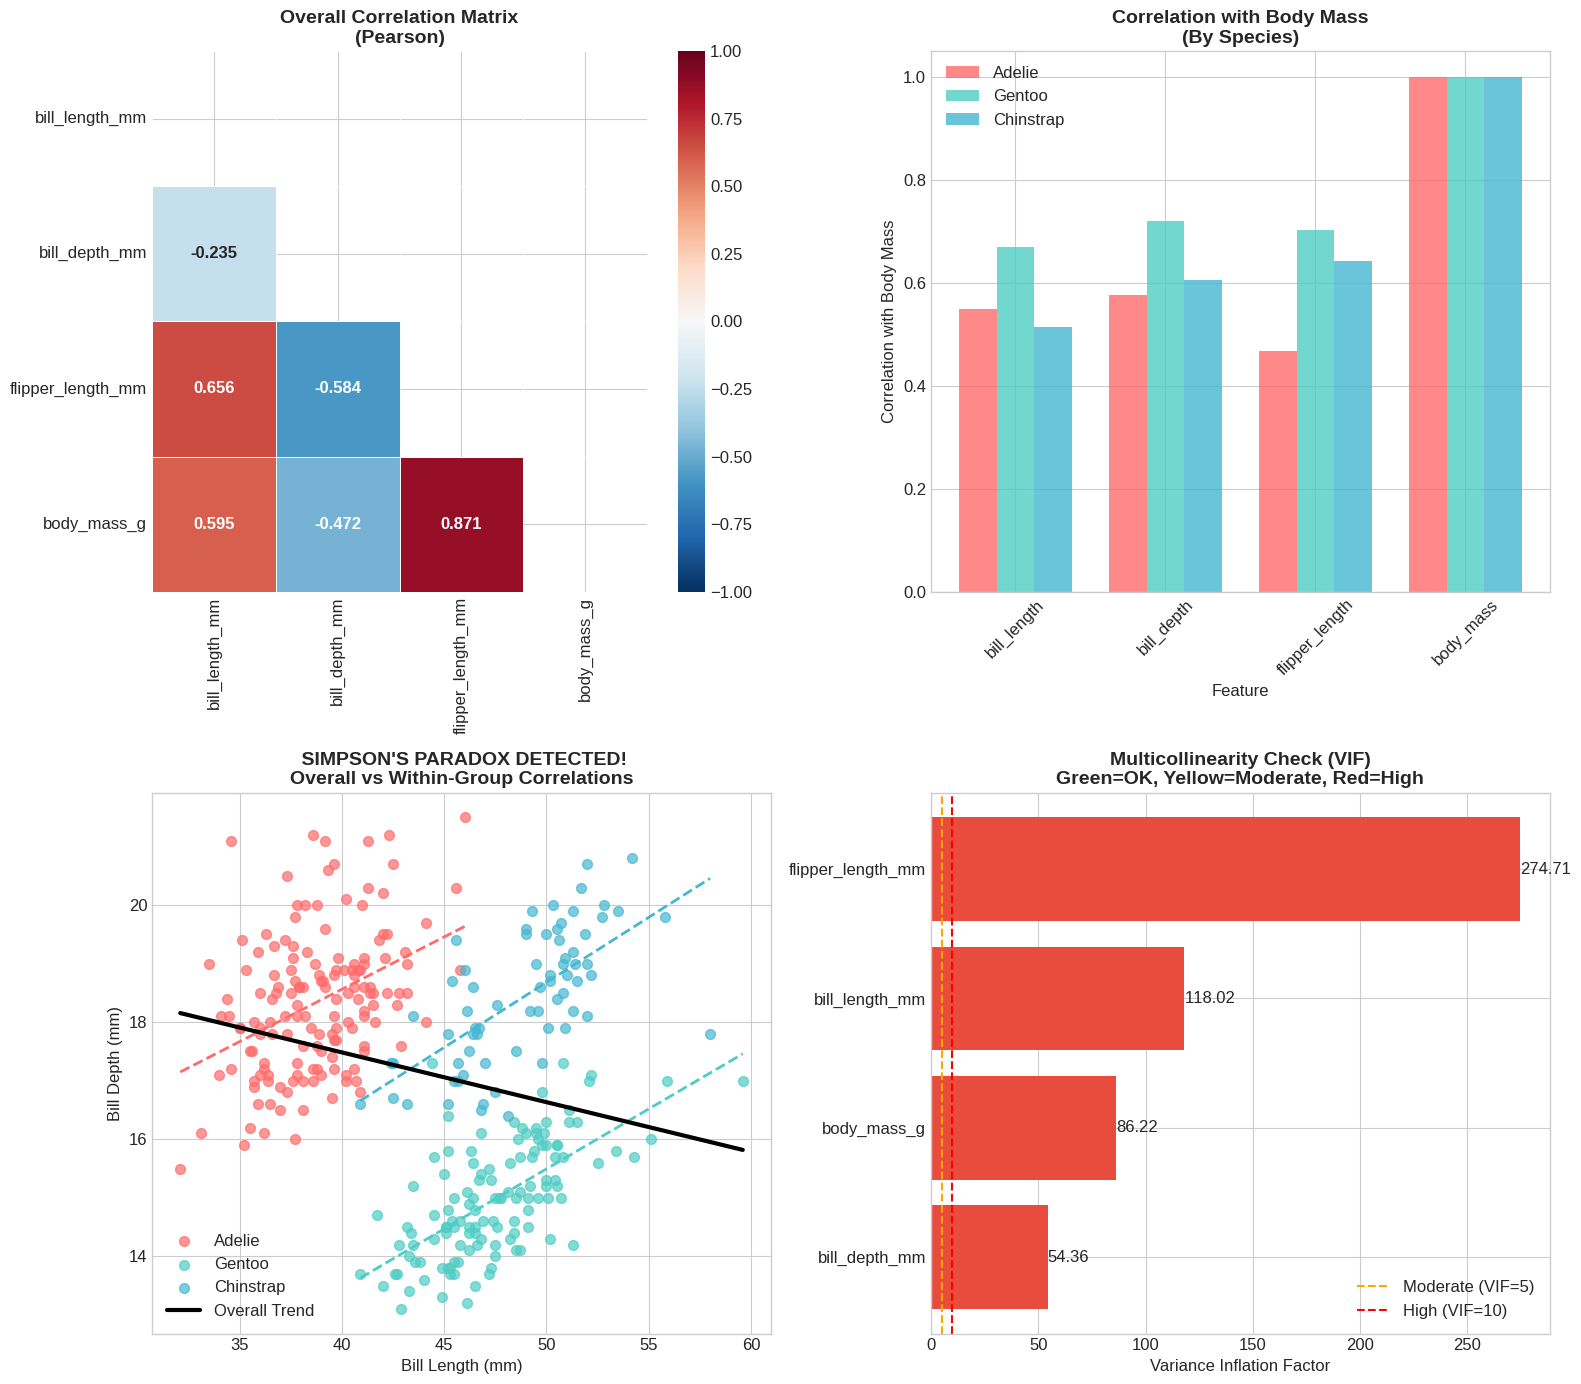


 KEY INSIGHT: Simpson's Paradox means we MUST use species-aware modeling!


In [25]:
# Advanced Correlation Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# 1. Overall Correlation Matrix
ax = axes[0, 0]
corr_matrix = df_clean[numerical_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.3f', ax=ax, vmin=-1, vmax=1, linewidths=0.5,
            annot_kws={'size': 12, 'weight': 'bold'})
ax.set_title('Overall Correlation Matrix\n(Pearson)', fontweight='bold')

# 2. Correlation by Species
ax = axes[0, 1]
corr_by_species = {}
x_pos = np.arange(len(numerical_cols))
width = 0.25

for i, species in enumerate([0, 1, 2]):
    species_data = df_clean[df_clean['species'] == species][numerical_cols]
    # Get correlation with bill_length (as example)
    corrs = [species_data[col].corr(species_data['body_mass_g']) for col in numerical_cols]
    corr_by_species[SPECIES_NAMES[species]] = corrs
    ax.bar(x_pos + i*width, corrs, width, label=SPECIES_NAMES[species],
           color=SPECIES_COLORS[species], alpha=0.8)

ax.set_xlabel('Feature')
ax.set_ylabel('Correlation with Body Mass')
ax.set_title('Correlation with Body Mass\n(By Species)', fontweight='bold')
ax.set_xticks(x_pos + width)
ax.set_xticklabels([c.replace('_mm', '').replace('_g', '') for c in numerical_cols], rotation=45)
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 3. Simpson's Paradox Detection (IMPORTANT!)
ax = axes[1, 0]
# Bill length vs Bill depth shows Simpson's Paradox
for species in [0, 1, 2]:
    data = df_clean[df_clean['species'] == species]
    ax.scatter(data['bill_length_mm'], data['bill_depth_mm'],
              c=SPECIES_COLORS[species], label=SPECIES_NAMES[species], alpha=0.7, s=50)
    # Add regression line per species
    z = np.polyfit(data['bill_length_mm'], data['bill_depth_mm'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(data['bill_length_mm'].min(), data['bill_length_mm'].max(), 100)
    ax.plot(x_line, p(x_line), c=SPECIES_COLORS[species], linewidth=2, linestyle='--')

# Overall regression line
z_overall = np.polyfit(df_clean['bill_length_mm'], df_clean['bill_depth_mm'], 1)
p_overall = np.poly1d(z_overall)
x_overall = np.linspace(df_clean['bill_length_mm'].min(), df_clean['bill_length_mm'].max(), 100)
ax.plot(x_overall, p_overall(x_overall), 'k-', linewidth=3, label='Overall Trend')

ax.set_xlabel('Bill Length (mm)')
ax.set_ylabel('Bill Depth (mm)')
ax.set_title(" SIMPSON'S PARADOX DETECTED!\nOverall vs Within-Group Correlations", fontweight='bold')
ax.legend()

# Calculate and display correlations
overall_corr = df_clean['bill_length_mm'].corr(df_clean['bill_depth_mm'])
print("\n SIMPSON'S PARADOX DETECTED!")
print("="*60)
print(f"Overall correlation (bill_length vs bill_depth): {overall_corr:.3f} (NEGATIVE)")
print("\nWithin-species correlations:")
for species in [0, 1, 2]:
    data = df_clean[df_clean['species'] == species]
    corr = data['bill_length_mm'].corr(data['bill_depth_mm'])
    print(f"  {SPECIES_NAMES[species]}: {corr:.3f} (POSITIVE)")

# 4. Variance Inflation Factor (VIF) for Multicollinearity
ax = axes[1, 1]
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = df_clean[numerical_cols]
vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_cols
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(len(numerical_cols))]
vif_data = vif_data.sort_values('VIF', ascending=True)

colors = ['#2ecc71' if v < 5 else '#f39c12' if v < 10 else '#e74c3c' for v in vif_data['VIF']]
bars = ax.barh(vif_data['Feature'], vif_data['VIF'], color=colors)
ax.axvline(x=5, color='orange', linestyle='--', label='Moderate (VIF=5)')
ax.axvline(x=10, color='red', linestyle='--', label='High (VIF=10)')
ax.set_xlabel('Variance Inflation Factor')
ax.set_title('Multicollinearity Check (VIF)\nGreen=OK, Yellow=Moderate, Red=High', fontweight='bold')
ax.legend()
for bar, vif in zip(bars, vif_data['VIF']):
    ax.text(vif + 0.1, bar.get_y() + bar.get_height()/2, f'{vif:.2f}', va='center')

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n KEY INSIGHT: Simpson's Paradox means we MUST use species-aware modeling!")

### Bivariate Relationships - Scatter Plot Matrix

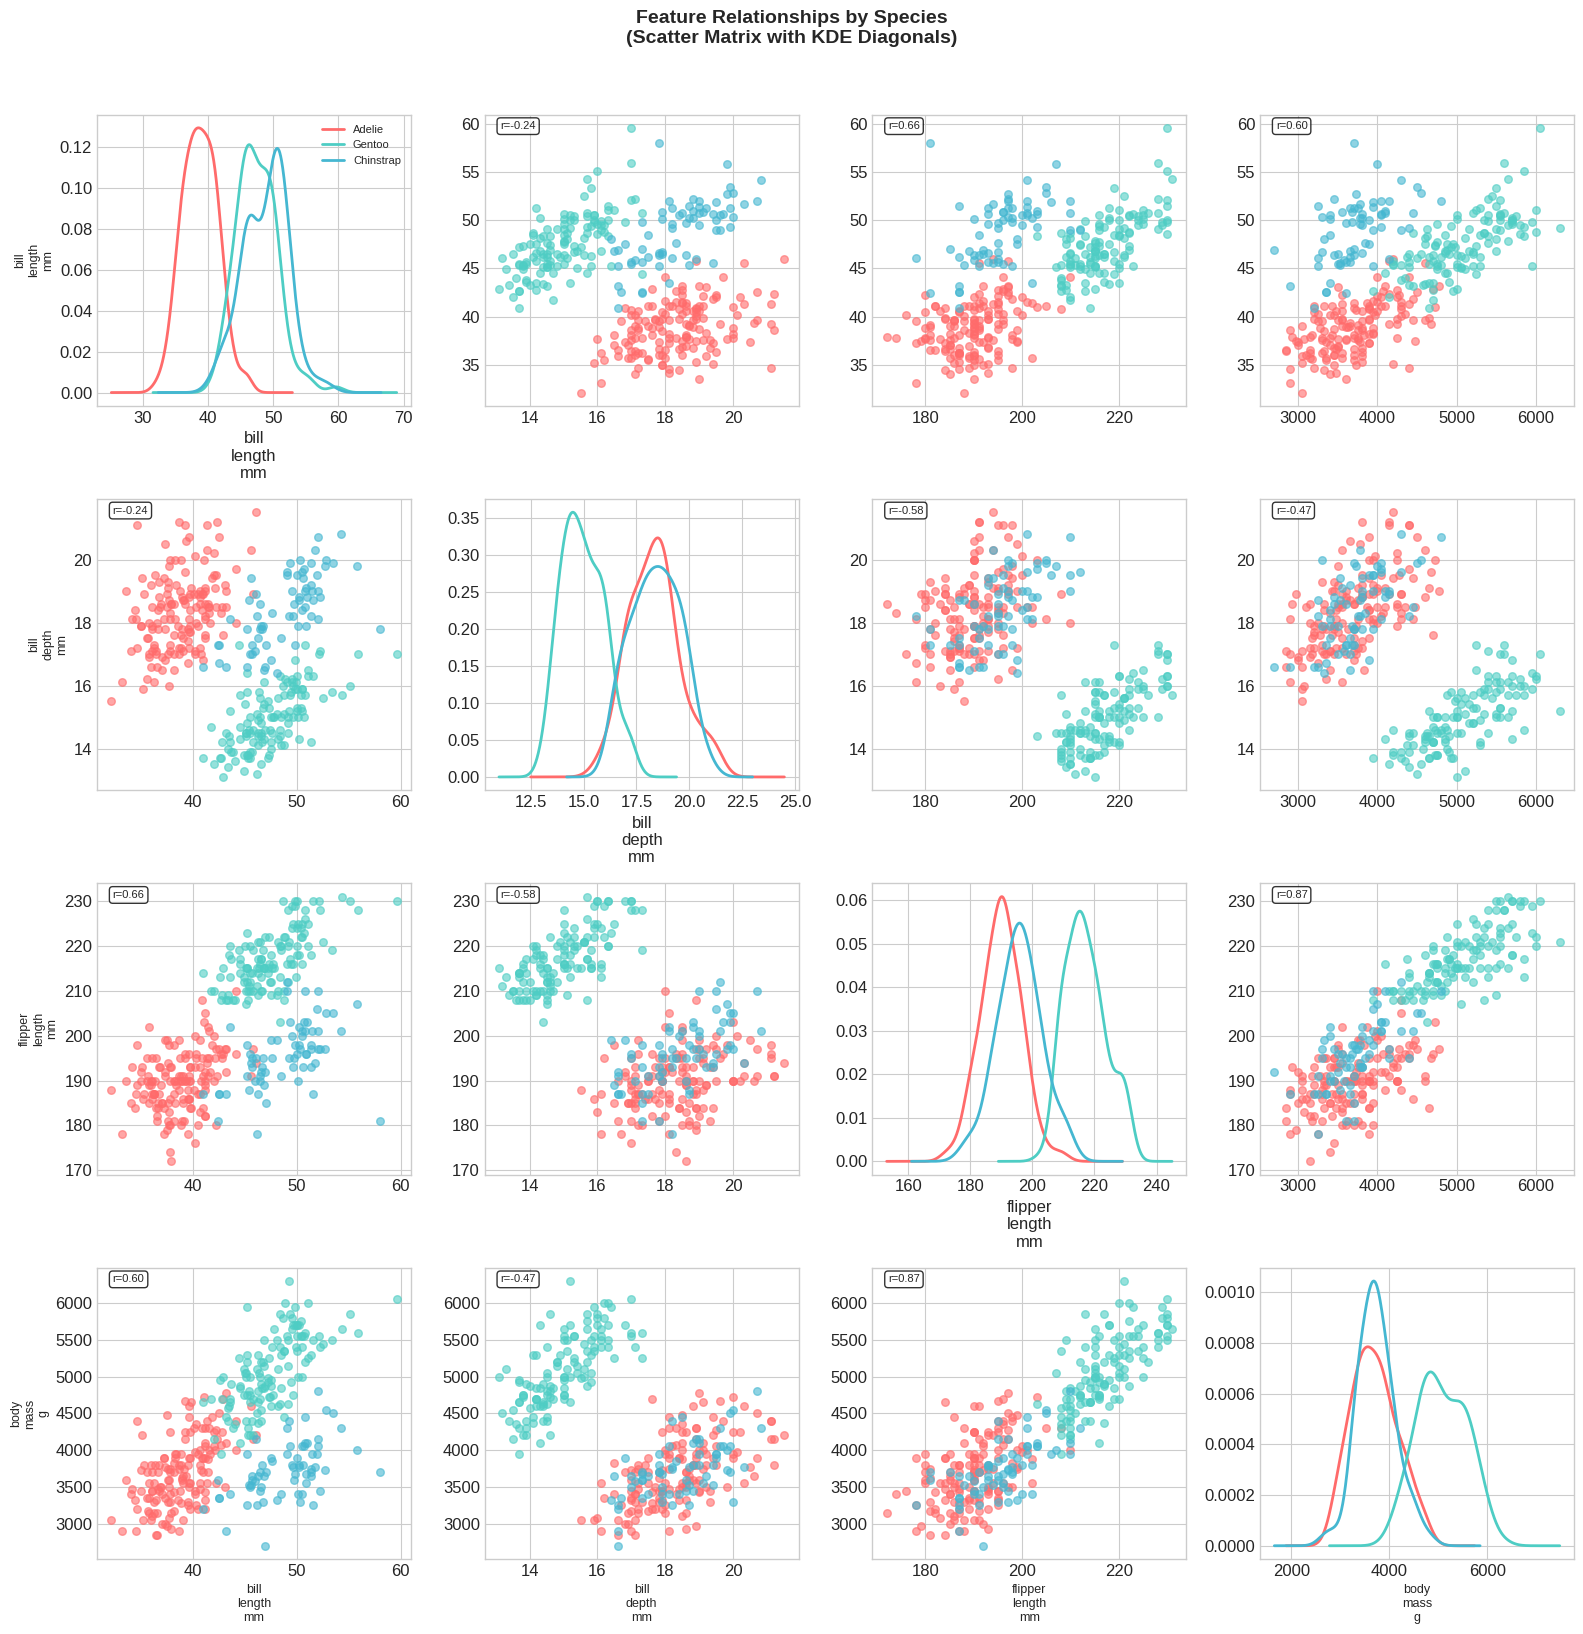


 BEST FEATURE PAIRS FOR SPECIES SEPARATION:
  • bill_depth_mm + flipper_length_mm: Separation Score = 3.440
  • bill_length_mm + flipper_length_mm: Separation Score = 3.299
  • bill_length_mm + bill_depth_mm: Separation Score = 2.363


In [26]:
# Enhanced Pairplot with Decision Boundaries Intuition
numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Create custom pairplot
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        ax = axes[i, j]

        if i == j:  # Diagonal - KDE
            for species in [0, 1, 2]:
                data = df_clean[df_clean['species'] == species][col1]
                if len(data) > 1:
                    data.plot.kde(ax=ax, color=SPECIES_COLORS[species],
                                 label=SPECIES_NAMES[species], linewidth=2)
            ax.set_ylabel('')
            ax.set_xlabel(col1.replace('_', '\n'))
            if i == 0:
                ax.legend(fontsize=8)
        else:  # Off-diagonal - Scatter
            for species in [0, 1, 2]:
                data = df_clean[df_clean['species'] == species]
                ax.scatter(data[col2], data[col1], c=SPECIES_COLORS[species],
                          alpha=0.6, s=30, label=SPECIES_NAMES[species])

            # Add correlation coefficient
            r, p = pearsonr(df_clean[col2], df_clean[col1])
            ax.annotate(f'r={r:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                       fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        if j == 0:
            ax.set_ylabel(col1.replace('_', '\n'), fontsize=9)
        if i == 3:
            ax.set_xlabel(col2.replace('_', '\n'), fontsize=9)

plt.suptitle('Feature Relationships by Species\n(Scatter Matrix with KDE Diagonals)',
            fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('pairplot_enhanced.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify best feature pairs for classification
print("\n BEST FEATURE PAIRS FOR SPECIES SEPARATION:")
print("="*60)
pairs_separation = []
for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        if i < j:
            # Calculate between-class vs within-class scatter ratio
            between_var = 0
            within_var = 0
            overall_mean1 = df_clean[col1].mean()
            overall_mean2 = df_clean[col2].mean()

            for species in [0, 1, 2]:
                data = df_clean[df_clean['species'] == species]
                n = len(data)
                class_mean1 = data[col1].mean()
                class_mean2 = data[col2].mean()
                between_var += n * ((class_mean1 - overall_mean1)**2 + (class_mean2 - overall_mean2)**2)
                within_var += data[col1].var() * n + data[col2].var() * n

            ratio = between_var / within_var if within_var > 0 else 0
            pairs_separation.append((col1, col2, ratio))

pairs_separation.sort(key=lambda x: x[2], reverse=True)
for col1, col2, ratio in pairs_separation[:3]:
    print(f"  • {col1} + {col2}: Separation Score = {ratio:.3f}")

### Sex and Island Impact Analysis

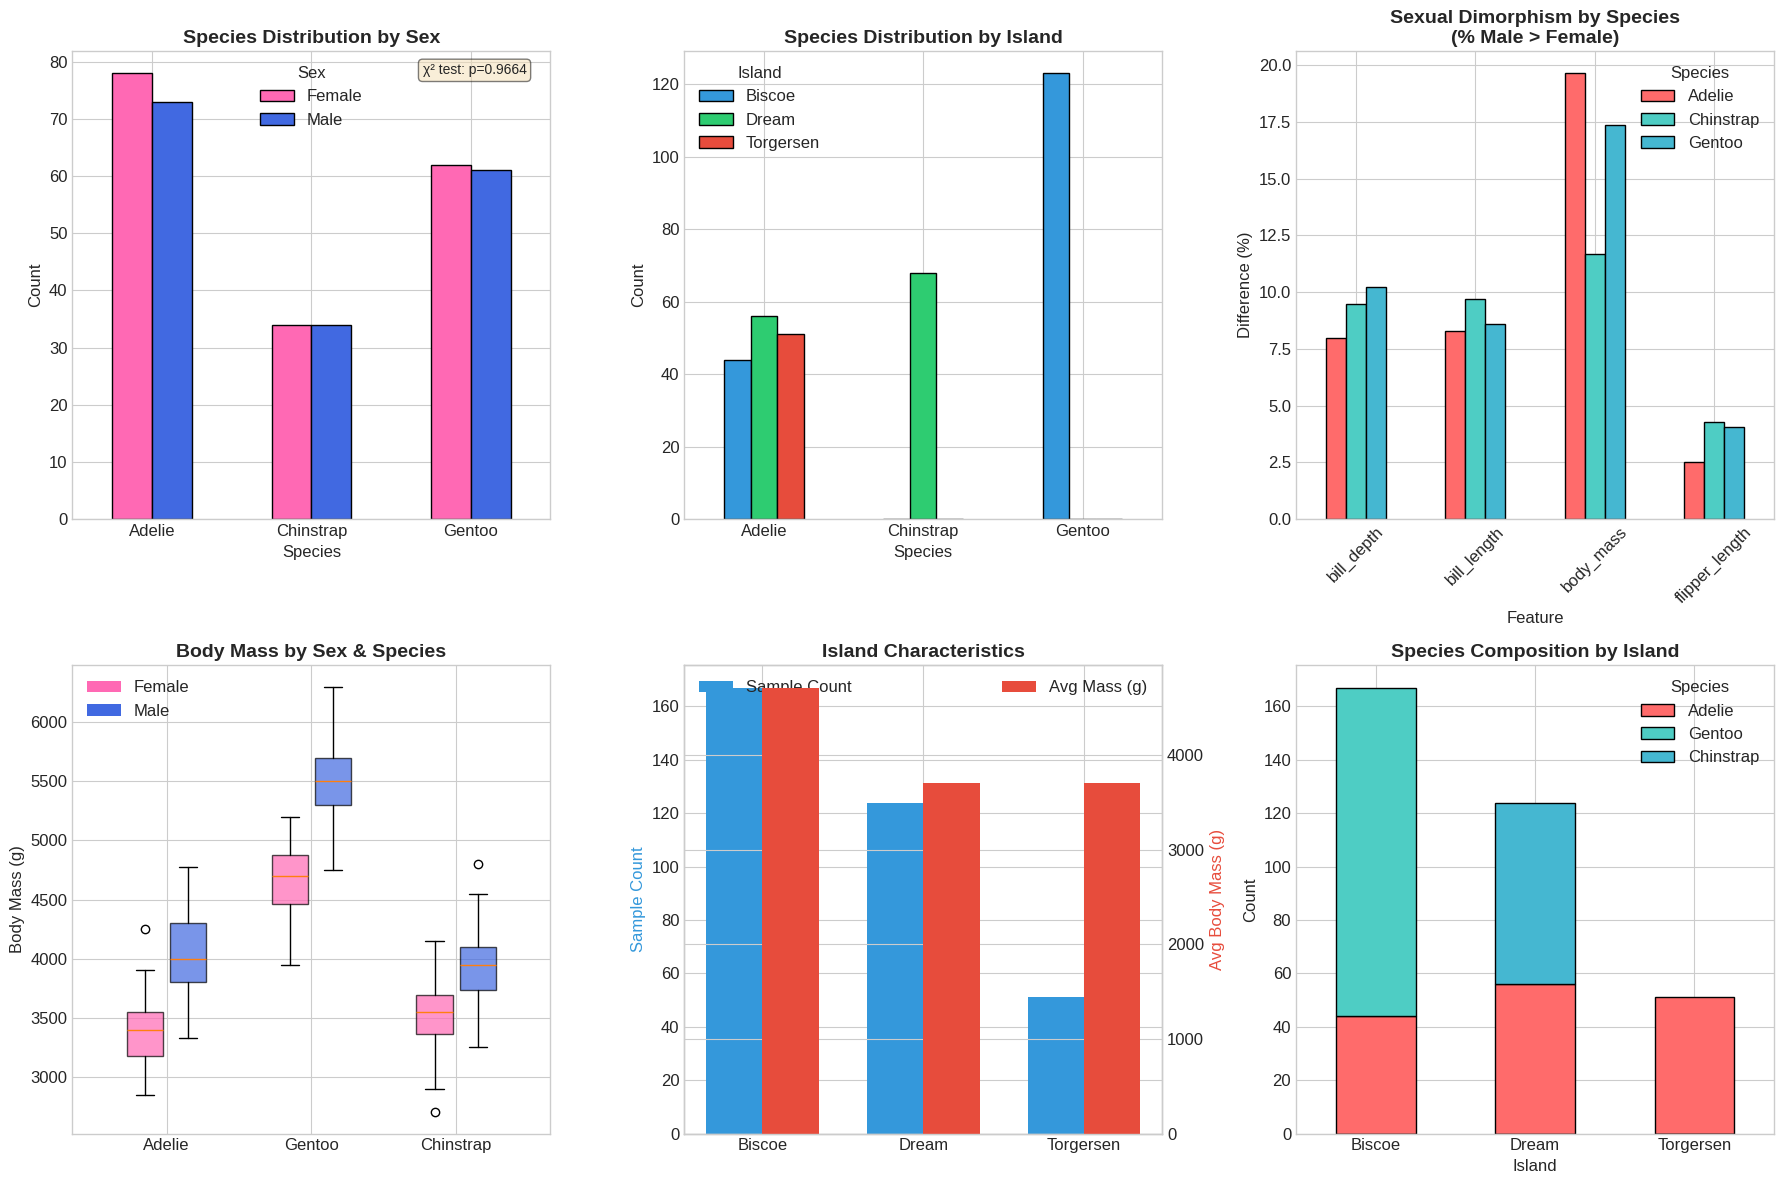


 KEY INSIGHTS:
  • Gentoo penguins are ONLY found on Biscoe Island
  • Chinstrap penguins are ONLY found on Dream Island
  • Adelie penguins are found on ALL three islands
  • Males are consistently larger than females across all species


In [27]:
# Categorical Variable Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Species distribution by Sex
ax = axes[0, 0]
ct_sex = pd.crosstab(df_clean['species'].map(SPECIES_NAMES),
                     df_clean['sex'].map({0: 'Female', 1: 'Male'}))
ct_sex.plot(kind='bar', ax=ax, color=['#FF69B4', '#4169E1'], edgecolor='black')
ax.set_title('Species Distribution by Sex', fontweight='bold')
ax.set_xlabel('Species')
ax.set_ylabel('Count')
ax.legend(title='Sex')
ax.tick_params(axis='x', rotation=0)

# Chi-square test
chi2, p_val, dof, expected = chi2_contingency(ct_sex)
ax.annotate(f'χ² test: p={p_val:.4f}', xy=(0.95, 0.95), xycoords='axes fraction',
           ha='right', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Species distribution by Island
ax = axes[0, 1]
island_cols = ['island_Biscoe', 'island_Dream', 'island_Torgersen']
island_data = []
for species in [0, 1, 2]:
    sp_data = df_clean[df_clean['species'] == species]
    for island in island_cols:
        island_data.append({
            'Species': SPECIES_NAMES[species],
            'Island': island.replace('island_', ''),
            'Count': sp_data[island].sum()
        })

island_df = pd.DataFrame(island_data)
island_pivot = island_df.pivot(index='Species', columns='Island', values='Count')
island_pivot.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')
ax.set_title('Species Distribution by Island', fontweight='bold')
ax.set_xlabel('Species')
ax.set_ylabel('Count')
ax.legend(title='Island')
ax.tick_params(axis='x', rotation=0)

# 3. Sexual Dimorphism Analysis
ax = axes[0, 2]
dimorphism = []
for col in ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']:
    for species in [0, 1, 2]:
        sp_data = df_clean[df_clean['species'] == species]
        male_mean = sp_data[sp_data['sex'] == 1][col].mean()
        female_mean = sp_data[sp_data['sex'] == 0][col].mean()
        diff_pct = ((male_mean - female_mean) / female_mean) * 100
        dimorphism.append({
            'Feature': col.replace('_mm', '').replace('_g', ''),
            'Species': SPECIES_NAMES[species],
            'Male-Female Diff (%)': diff_pct
        })

dim_df = pd.DataFrame(dimorphism)
dim_pivot = dim_df.pivot(index='Feature', columns='Species', values='Male-Female Diff (%)')
dim_pivot.plot(kind='bar', ax=ax, color=[SPECIES_COLORS[s] for s in [0, 1, 2]], edgecolor='black')
ax.set_title('Sexual Dimorphism by Species\n(% Male > Female)', fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Difference (%)')
ax.legend(title='Species')
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 4. Body Mass by Sex and Species
ax = axes[1, 0]
for species in [0, 1, 2]:
    for sex, offset in [(0, -0.15), (1, 0.15)]:
        data = df_clean[(df_clean['species'] == species) & (df_clean['sex'] == sex)]['body_mass_g']
        bp = ax.boxplot([data], positions=[species + offset], widths=0.25, patch_artist=True)
        color = '#FF69B4' if sex == 0 else '#4169E1'
        bp['boxes'][0].set_facecolor(color)
        bp['boxes'][0].set_alpha(0.7)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([SPECIES_NAMES[s] for s in [0, 1, 2]])
ax.set_title('Body Mass by Sex & Species', fontweight='bold')
ax.set_ylabel('Body Mass (g)')
ax.legend([plt.Rectangle((0,0),1,1,fc='#FF69B4'), plt.Rectangle((0,0),1,1,fc='#4169E1')],
         ['Female', 'Male'], loc='upper left')

# 5. Island habitat analysis
ax = axes[1, 1]
island_stats = []
for island in ['Biscoe', 'Dream', 'Torgersen']:
    island_data = df_clean[df_clean[f'island_{island}'] == 1]
    island_stats.append({
        'Island': island,
        'N': len(island_data),
        'Species': len(island_data['species'].unique()),
        'Avg Body Mass': island_data['body_mass_g'].mean()
    })
island_stats_df = pd.DataFrame(island_stats)

x = np.arange(len(island_stats_df))
width = 0.35
bars1 = ax.bar(x - width/2, island_stats_df['N'], width, label='Sample Count', color='#3498db')
ax2_twin = ax.twinx()
bars2 = ax2_twin.bar(x + width/2, island_stats_df['Avg Body Mass'], width, label='Avg Mass (g)', color='#e74c3c')
ax.set_xticks(x)
ax.set_xticklabels(island_stats_df['Island'])
ax.set_ylabel('Sample Count', color='#3498db')
ax2_twin.set_ylabel('Avg Body Mass (g)', color='#e74c3c')
ax.set_title('Island Characteristics', fontweight='bold')
ax.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# 6. Species exclusivity by island
ax = axes[1, 2]
exclusivity = {}
for island in ['Biscoe', 'Dream', 'Torgersen']:
    island_data = df_clean[df_clean[f'island_{island}'] == 1]
    species_counts = island_data['species'].value_counts()
    exclusivity[island] = {SPECIES_NAMES[s]: species_counts.get(s, 0) for s in [0, 1, 2]}

excl_df = pd.DataFrame(exclusivity).T
excl_df.plot(kind='bar', stacked=True, ax=ax, color=[SPECIES_COLORS[s] for s in [0, 1, 2]], edgecolor='black')
ax.set_title('Species Composition by Island', fontweight='bold')
ax.set_xlabel('Island')
ax.set_ylabel('Count')
ax.legend(title='Species')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('categorical_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n KEY INSIGHTS:")
print("  • Gentoo penguins are ONLY found on Biscoe Island")
print("  • Chinstrap penguins are ONLY found on Dream Island")
print("  • Adelie penguins are found on ALL three islands")
print("  • Males are consistently larger than females across all species")

### Outlier Detection & Analysis

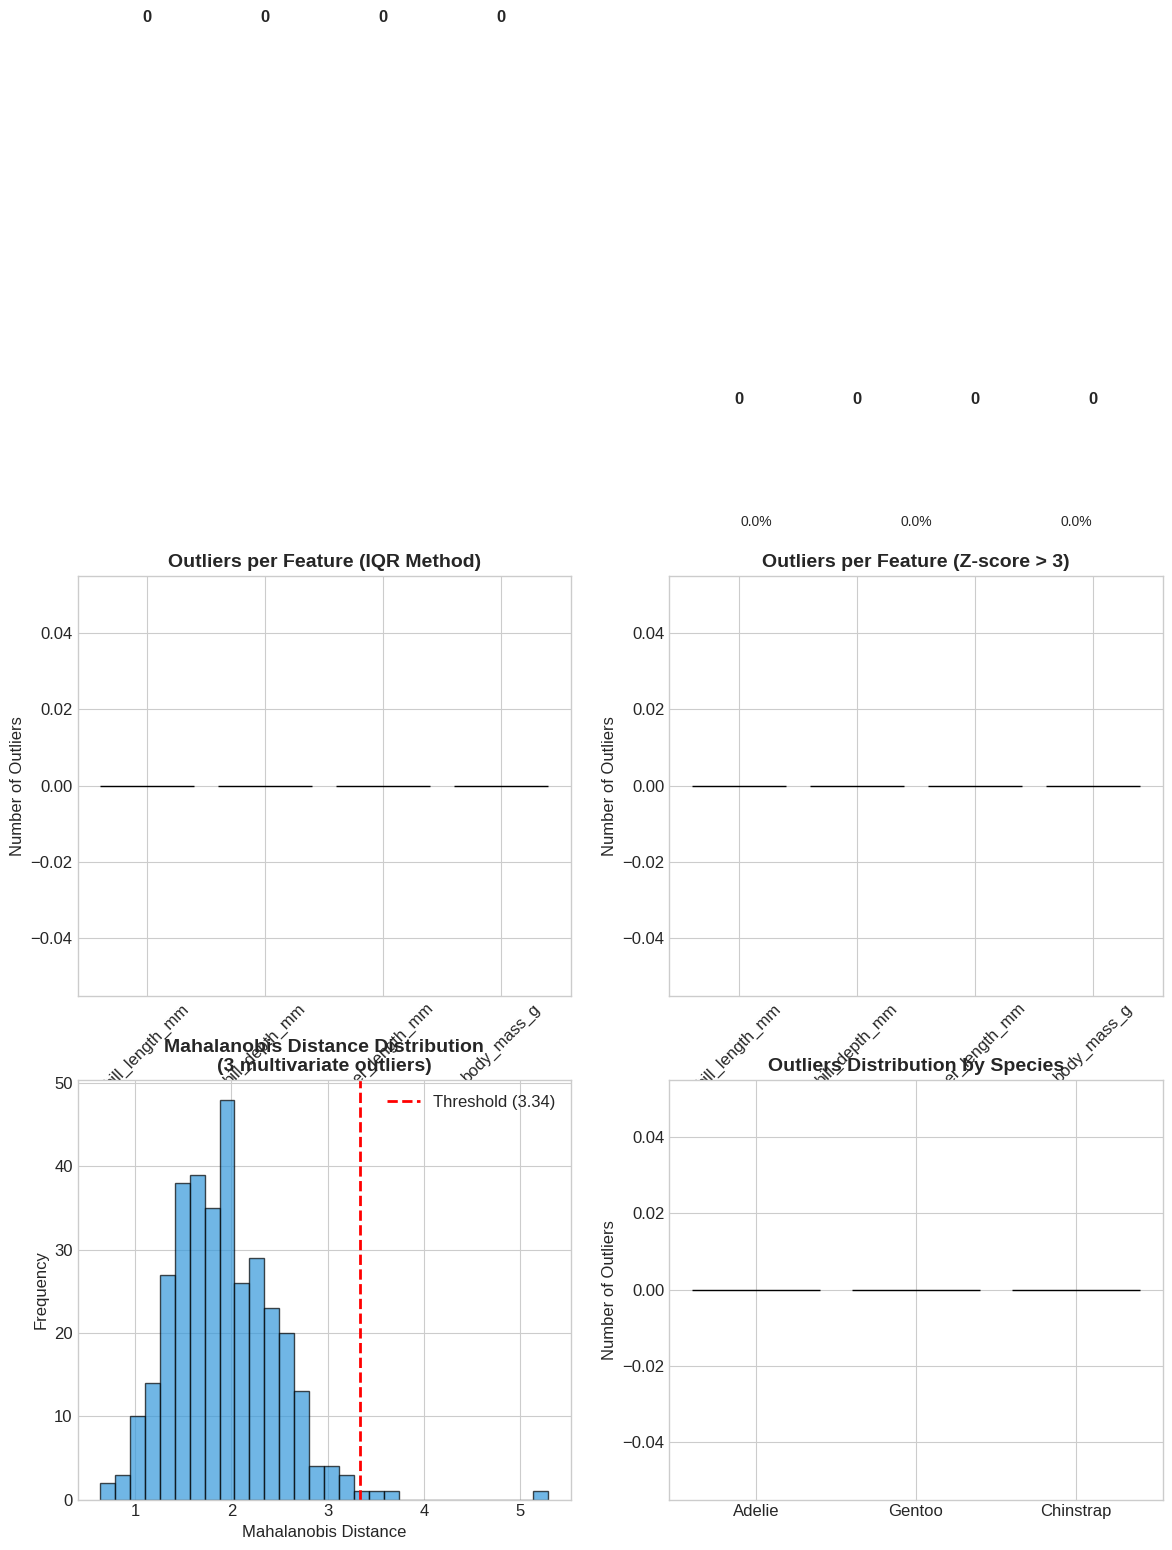


 OUTLIER SUMMARY:
  • Total unique outliers (IQR): 0 (0.0%)
  • Multivariate outliers (Mahalanobis): 3

 RECOMMENDATION: Outliers appear to be natural variation, not errors. Keep them for robust modeling.


In [28]:
# Comprehensive Outlier Analysis
from scipy.stats import zscore

numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. IQR-based outlier detection
ax = axes[0, 0]
outlier_counts = {}
outlier_indices = set()

for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)]
    outlier_counts[col] = len(outliers)
    outlier_indices.update(outliers.index)

bars = ax.bar(outlier_counts.keys(), outlier_counts.values(), color='#e74c3c', edgecolor='black')
ax.set_title('Outliers per Feature (IQR Method)', fontweight='bold')
ax.set_ylabel('Number of Outliers')
ax.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, outlier_counts.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, str(count),
            ha='center', fontweight='bold')

# 2. Z-score based outlier detection
ax = axes[0, 1]
z_outliers = {}
for col in numerical_cols:
    z_scores = np.abs(zscore(df_clean[col]))
    z_outliers[col] = (z_scores > 3).sum()

bars = ax.bar(z_outliers.keys(), z_outliers.values(), color='#9b59b6', edgecolor='black')
ax.set_title('Outliers per Feature (Z-score > 3)', fontweight='bold')
ax.set_ylabel('Number of Outliers')
ax.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, z_outliers.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, str(count),
            ha='center', fontweight='bold')

# 3. Multivariate outlier detection (Mahalanobis distance)
ax = axes[1, 0]
from scipy.spatial.distance import mahalanobis

X = df_clean[numerical_cols].values
mean = np.mean(X, axis=0)
cov = np.cov(X.T)
cov_inv = np.linalg.inv(cov)

mahal_dist = [mahalanobis(x, mean, cov_inv) for x in X]
df_clean['mahal_dist'] = mahal_dist

# Chi-square critical value for 4 degrees of freedom at 97.5%
chi2_critical = stats.chi2.ppf(0.975, df=4)
multivariate_outliers = df_clean[df_clean['mahal_dist'] > np.sqrt(chi2_critical)]

ax.hist(mahal_dist, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax.axvline(x=np.sqrt(chi2_critical), color='red', linestyle='--', linewidth=2,
          label=f'Threshold ({np.sqrt(chi2_critical):.2f})')
ax.set_title(f'Mahalanobis Distance Distribution\n({len(multivariate_outliers)} multivariate outliers)', fontweight='bold')
ax.set_xlabel('Mahalanobis Distance')
ax.set_ylabel('Frequency')
ax.legend()

# 4. Outliers by species
ax = axes[1, 1]
outlier_by_species = df_clean.loc[list(outlier_indices)]['species'].value_counts()
for species in [0, 1, 2]:
    if species not in outlier_by_species.index:
        outlier_by_species[species] = 0

species_names = [SPECIES_NAMES[s] for s in outlier_by_species.index]
colors = [SPECIES_COLORS[s] for s in outlier_by_species.index]
ax.bar(species_names, outlier_by_species.values, color=colors, edgecolor='black')
ax.set_title('Outliers Distribution by Species', fontweight='bold')
ax.set_ylabel('Number of Outliers')

# Add percentage labels
total_by_species = df_clean['species'].value_counts()
for i, (species, count) in enumerate(outlier_by_species.items()):
    pct = (count / total_by_species[species]) * 100
    ax.text(i, count + 0.2, f'{pct:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('outlier_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Clean up
df_clean = df_clean.drop('mahal_dist', axis=1)

print(f"\n OUTLIER SUMMARY:")
print(f"  • Total unique outliers (IQR): {len(outlier_indices)} ({len(outlier_indices)/len(df_clean)*100:.1f}%)")
print(f"  • Multivariate outliers (Mahalanobis): {len(multivariate_outliers)}")
print("\n RECOMMENDATION: Outliers appear to be natural variation, not errors. Keep them for robust modeling.")

### Dimensionality Reduction Visualization (PCA + t-SNE)

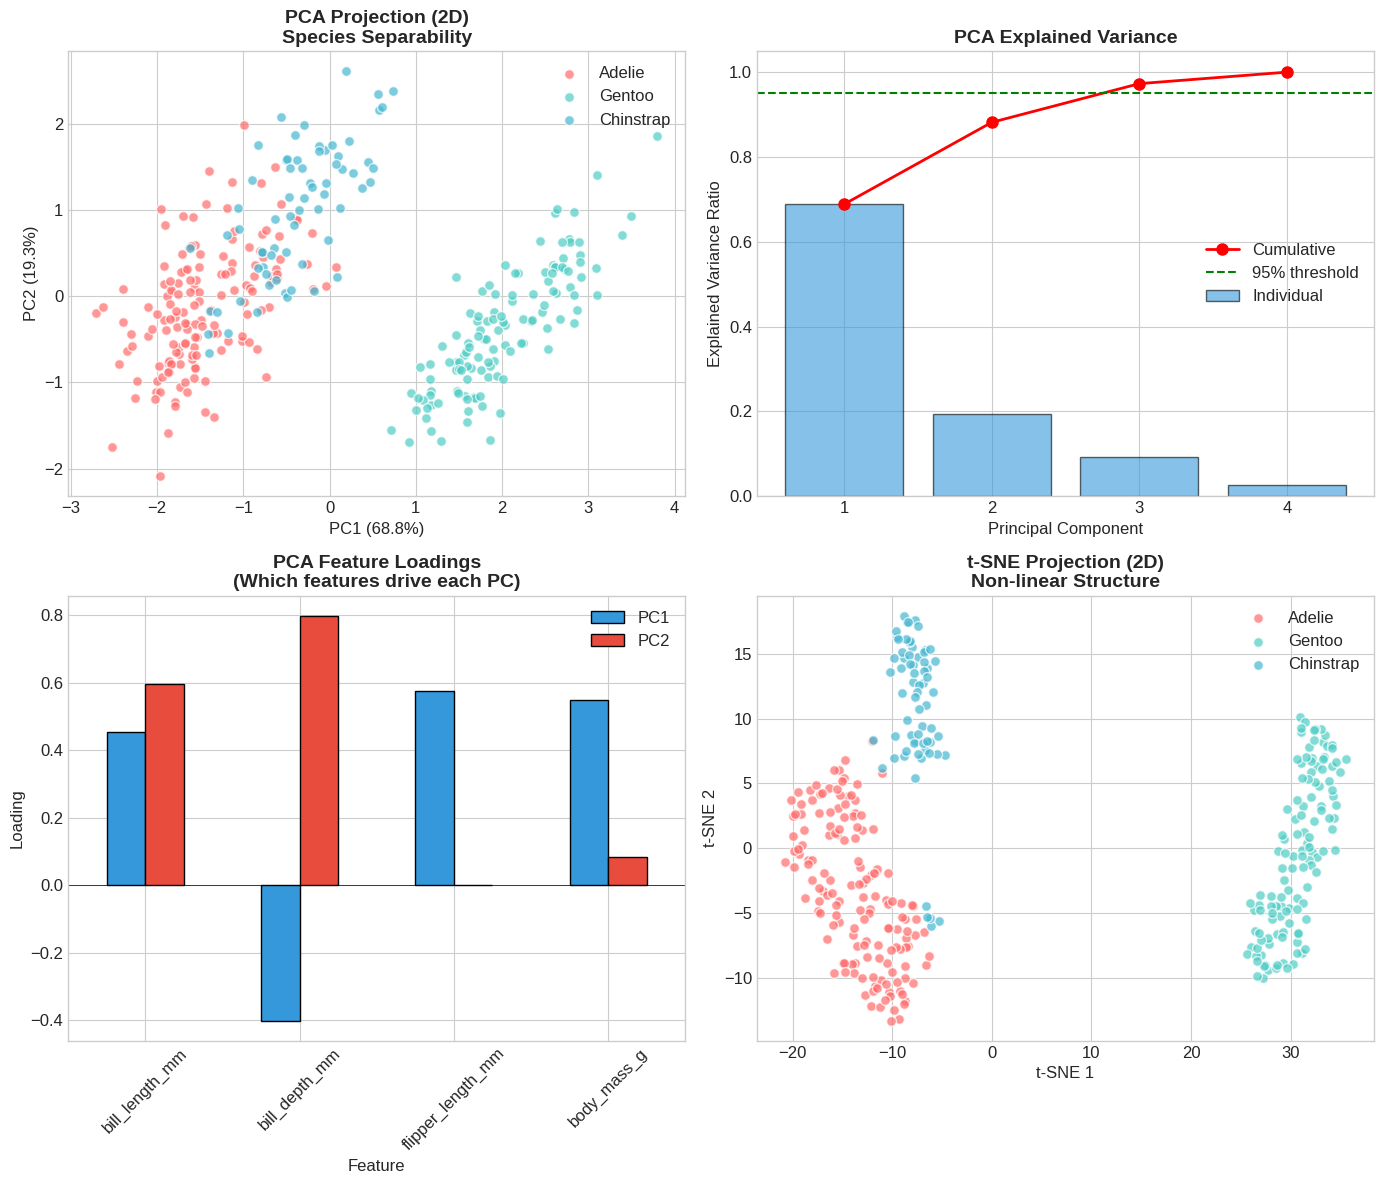


 PCA INSIGHTS:
  • PC1 + PC2 explain 88.2% of variance
  • All 4 components needed for 100% variance

 Species clusters are well-separated in both PCA and t-SNE → Classification should work well!


In [29]:
# Dimensionality Reduction for Visualization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[numerical_cols])

# 1. PCA - 2D projection
ax = axes[0, 0]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for species in [0, 1, 2]:
    mask = df_clean['species'] == species
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=SPECIES_COLORS[species],
              label=SPECIES_NAMES[species], alpha=0.7, s=50, edgecolor='white')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA Projection (2D)\nSpecies Separability', fontweight='bold')
ax.legend()

# 2. PCA - Explained variance
ax = axes[0, 1]
pca_full = PCA()
pca_full.fit(X_scaled)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

ax.bar(range(1, 5), pca_full.explained_variance_ratio_, alpha=0.6,
       color='#3498db', label='Individual', edgecolor='black')
ax.plot(range(1, 5), cumsum, 'ro-', linewidth=2, markersize=8, label='Cumulative')
ax.axhline(y=0.95, color='green', linestyle='--', label='95% threshold')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('PCA Explained Variance', fontweight='bold')
ax.legend()
ax.set_xticks([1, 2, 3, 4])

# 3. PCA Loadings (Feature contributions)
ax = axes[1, 0]
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=numerical_cols)
loadings.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'], edgecolor='black')
ax.set_title('PCA Feature Loadings\n(Which features drive each PC)', fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Loading')
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.legend()

# 4. t-SNE projection
ax = axes[1, 1]
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

for species in [0, 1, 2]:
    mask = df_clean['species'] == species
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=SPECIES_COLORS[species],
              label=SPECIES_NAMES[species], alpha=0.7, s=50, edgecolor='white')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE Projection (2D)\nNon-linear Structure', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('dimensionality_reduction.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n PCA INSIGHTS:")
print(f"  • PC1 + PC2 explain {cumsum[1]*100:.1f}% of variance")
print(f"  • All 4 components needed for 100% variance")
print("\n Species clusters are well-separated in both PCA and t-SNE → Classification should work well!")

### Feature Engineering Ideas from EDA

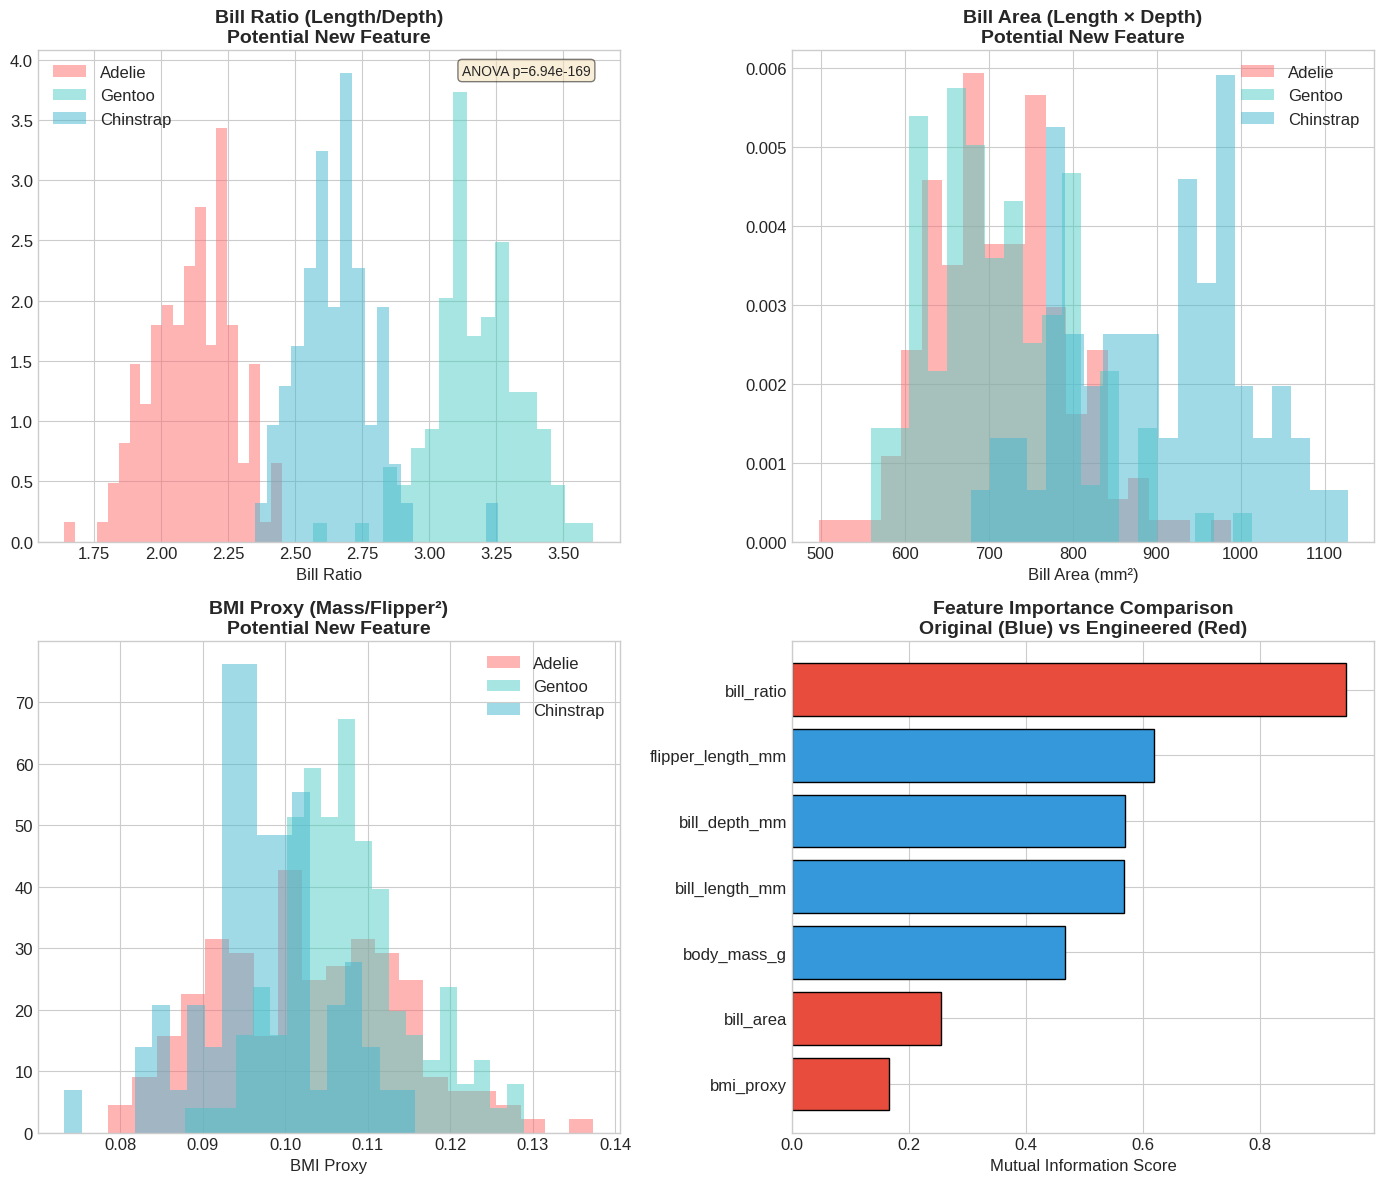


 FEATURE ENGINEERING RECOMMENDATIONS:
  1. Bill Ratio (length/depth) - HIGH discriminative power for Gentoo
  2. Bill Area (length × depth) - Captures bill size holistically
  3. BMI Proxy - May help separate body composition differences
  4. Island features are HIGHLY predictive (near-perfect for some species)


In [30]:
# Feature Engineering Suggestions Based on EDA
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Bill Ratio (length/depth) - potential new feature
df_clean['bill_ratio'] = df_clean['bill_length_mm'] / df_clean['bill_depth_mm']

ax = axes[0, 0]
for species in [0, 1, 2]:
    data = df_clean[df_clean['species'] == species]['bill_ratio']
    ax.hist(data, bins=20, alpha=0.5, label=SPECIES_NAMES[species],
           color=SPECIES_COLORS[species], density=True)
ax.set_title('Bill Ratio (Length/Depth)\nPotential New Feature', fontweight='bold')
ax.set_xlabel('Bill Ratio')
ax.legend()

# ANOVA test
f_stat, p_val = f_oneway(*[df_clean[df_clean['species'] == s]['bill_ratio'] for s in [0, 1, 2]])
ax.annotate(f'ANOVA p={p_val:.2e}', xy=(0.95, 0.95), xycoords='axes fraction',
           ha='right', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Bill Area proxy (length * depth)
df_clean['bill_area'] = df_clean['bill_length_mm'] * df_clean['bill_depth_mm']

ax = axes[0, 1]
for species in [0, 1, 2]:
    data = df_clean[df_clean['species'] == species]['bill_area']
    ax.hist(data, bins=20, alpha=0.5, label=SPECIES_NAMES[species],
           color=SPECIES_COLORS[species], density=True)
ax.set_title('Bill Area (Length × Depth)\nPotential New Feature', fontweight='bold')
ax.set_xlabel('Bill Area (mm²)')
ax.legend()

# 3. Body Mass Index proxy
df_clean['bmi_proxy'] = df_clean['body_mass_g'] / (df_clean['flipper_length_mm'] ** 2)

ax = axes[1, 0]
for species in [0, 1, 2]:
    data = df_clean[df_clean['species'] == species]['bmi_proxy']
    ax.hist(data, bins=20, alpha=0.5, label=SPECIES_NAMES[species],
           color=SPECIES_COLORS[species], density=True)
ax.set_title('BMI Proxy (Mass/Flipper²)\nPotential New Feature', fontweight='bold')
ax.set_xlabel('BMI Proxy')
ax.legend()

# 4. Compare Mutual Information of new vs original features
ax = axes[1, 1]
all_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g',
                'bill_ratio', 'bill_area', 'bmi_proxy']
X_all = df_clean[all_features]
y = df_clean['species']
mi_scores = mutual_info_classif(X_all, y, random_state=42)

mi_df = pd.DataFrame({'Feature': all_features, 'MI Score': mi_scores}).sort_values('MI Score', ascending=True)
colors = ['#e74c3c' if 'ratio' in f or 'area' in f or 'bmi' in f else '#3498db' for f in mi_df['Feature']]
bars = ax.barh(mi_df['Feature'], mi_df['MI Score'], color=colors, edgecolor='black')
ax.set_title('Feature Importance Comparison\nOriginal (Blue) vs Engineered (Red)', fontweight='bold')
ax.set_xlabel('Mutual Information Score')

plt.tight_layout()
plt.savefig('feature_engineering.png', dpi=150, bbox_inches='tight')
plt.show()

# Clean up temporary columns
df_clean = df_clean.drop(['bill_ratio', 'bill_area', 'bmi_proxy'], axis=1)

print("\n FEATURE ENGINEERING RECOMMENDATIONS:")
print("="*60)
print("  1. Bill Ratio (length/depth) - HIGH discriminative power for Gentoo")
print("  2. Bill Area (length × depth) - Captures bill size holistically")
print("  3. BMI Proxy - May help separate body composition differences")
print("  4. Island features are HIGHLY predictive (near-perfect for some species)")

### Statistical Hypothesis Testing Summary

In [31]:
# Comprehensive Statistical Testing
print("="*80)
print(" COMPREHENSIVE STATISTICAL TESTING SUMMARY")
print("="*80)

numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# 1. Normality tests (Shapiro-Wilk)
print("\n1️ NORMALITY TESTS (Shapiro-Wilk)")
print("-"*60)
normality_results = []
for col in numerical_cols:
    for species in [0, 1, 2]:
        data = df_clean[df_clean['species'] == species][col]
        stat, p = stats.shapiro(data)
        is_normal = "Yes ✓" if p > 0.05 else "No ✗"
        normality_results.append({
            'Feature': col,
            'Species': SPECIES_NAMES[species],
            'p-value': p,
            'Normal': is_normal
        })

norm_df = pd.DataFrame(normality_results)
print(norm_df.to_string(index=False))

# 2. Homogeneity of Variance (Levene's test)
print("\n2️ HOMOGENEITY OF VARIANCE (Levene's Test)")
print("-"*60)
for col in numerical_cols:
    groups = [df_clean[df_clean['species'] == s][col] for s in [0, 1, 2]]
    stat, p = stats.levene(*groups)
    equal_var = "Yes ✓" if p > 0.05 else "No ✗"
    print(f"  {col}: p={p:.4f} → Equal variance: {equal_var}")

# 3. ANOVA / Kruskal-Wallis
print("\n3️ SPECIES COMPARISON TESTS")
print("-"*60)
for col in numerical_cols:
    groups = [df_clean[df_clean['species'] == s][col] for s in [0, 1, 2]]

    # Check normality
    normal = all(stats.shapiro(g)[1] > 0.05 for g in groups)

    if normal:
        stat, p = f_oneway(*groups)
        test_name = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_name = "Kruskal-Wallis"

    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    print(f"  {col}: {test_name} → p={p:.2e} {sig}")

# 4. Chi-square tests for categorical variables
print("\n4️ CHI-SQUARE TESTS (Categorical Independence)")
print("-"*60)

# Sex vs Species
contingency_sex = pd.crosstab(df_clean['species'], df_clean['sex'])
chi2, p, dof, expected = chi2_contingency(contingency_sex)
print(f"  Sex × Species: χ²={chi2:.2f}, p={p:.4f} → {'Dependent' if p < 0.05 else 'Independent'}")

# Island vs Species
for island in ['island_Biscoe', 'island_Dream', 'island_Torgersen']:
    contingency_island = pd.crosstab(df_clean['species'], df_clean[island])
    chi2, p, dof, expected = chi2_contingency(contingency_island)
    print(f"  {island.replace('island_', '')} × Species: χ²={chi2:.2f}, p={p:.4f} → {'Dependent' if p < 0.05 else 'Independent'}")

# 5. Effect sizes summary
print("\n5️ EFFECT SIZE SUMMARY (η² - Eta Squared)")
print("-"*60)
for col in numerical_cols:
    groups = [df_clean[df_clean['species'] == s][col] for s in [0, 1, 2]]

    # Calculate eta-squared
    ss_between = sum(len(g) * (g.mean() - df_clean[col].mean())**2 for g in groups)
    ss_total = sum((df_clean[col] - df_clean[col].mean())**2)
    eta_sq = ss_between / ss_total

    interpretation = "Large" if eta_sq > 0.14 else "Medium" if eta_sq > 0.06 else "Small"
    print(f"  {col}: η² = {eta_sq:.3f} ({interpretation} effect)")

print("\n" + "="*80)
print(" CONCLUSION: All features show statistically significant differences")
print("   between species with large effect sizes → Strong predictive potential!")
print("="*80)

 COMPREHENSIVE STATISTICAL TESTING SUMMARY

1️ NORMALITY TESTS (Shapiro-Wilk)
------------------------------------------------------------
          Feature   Species  p-value Normal
   bill_length_mm    Adelie 0.716601  Yes ✓
   bill_length_mm    Gentoo 0.013491   No ✗
   bill_length_mm Chinstrap 0.194093  Yes ✓
    bill_depth_mm    Adelie 0.092490  Yes ✓
    bill_depth_mm    Gentoo 0.027695   No ✗
    bill_depth_mm Chinstrap 0.141785  Yes ✓
flipper_length_mm    Adelie 0.720047  Yes ✓
flipper_length_mm    Gentoo 0.001620   No ✗
flipper_length_mm Chinstrap 0.810645  Yes ✓
      body_mass_g    Adelie 0.032397   No ✗
      body_mass_g    Gentoo 0.233616  Yes ✓
      body_mass_g Chinstrap 0.560508  Yes ✓

2️ HOMOGENEITY OF VARIANCE (Levene's Test)
------------------------------------------------------------
  bill_length_mm: p=0.1078 → Equal variance: Yes ✓
  bill_depth_mm: p=0.1320 → Equal variance: Yes ✓
  flipper_length_mm: p=0.7188 → Equal variance: Yes ✓
  body_mass_g: p=0.0064 → Equ

### Final EDA Summary & Modeling Recommendations

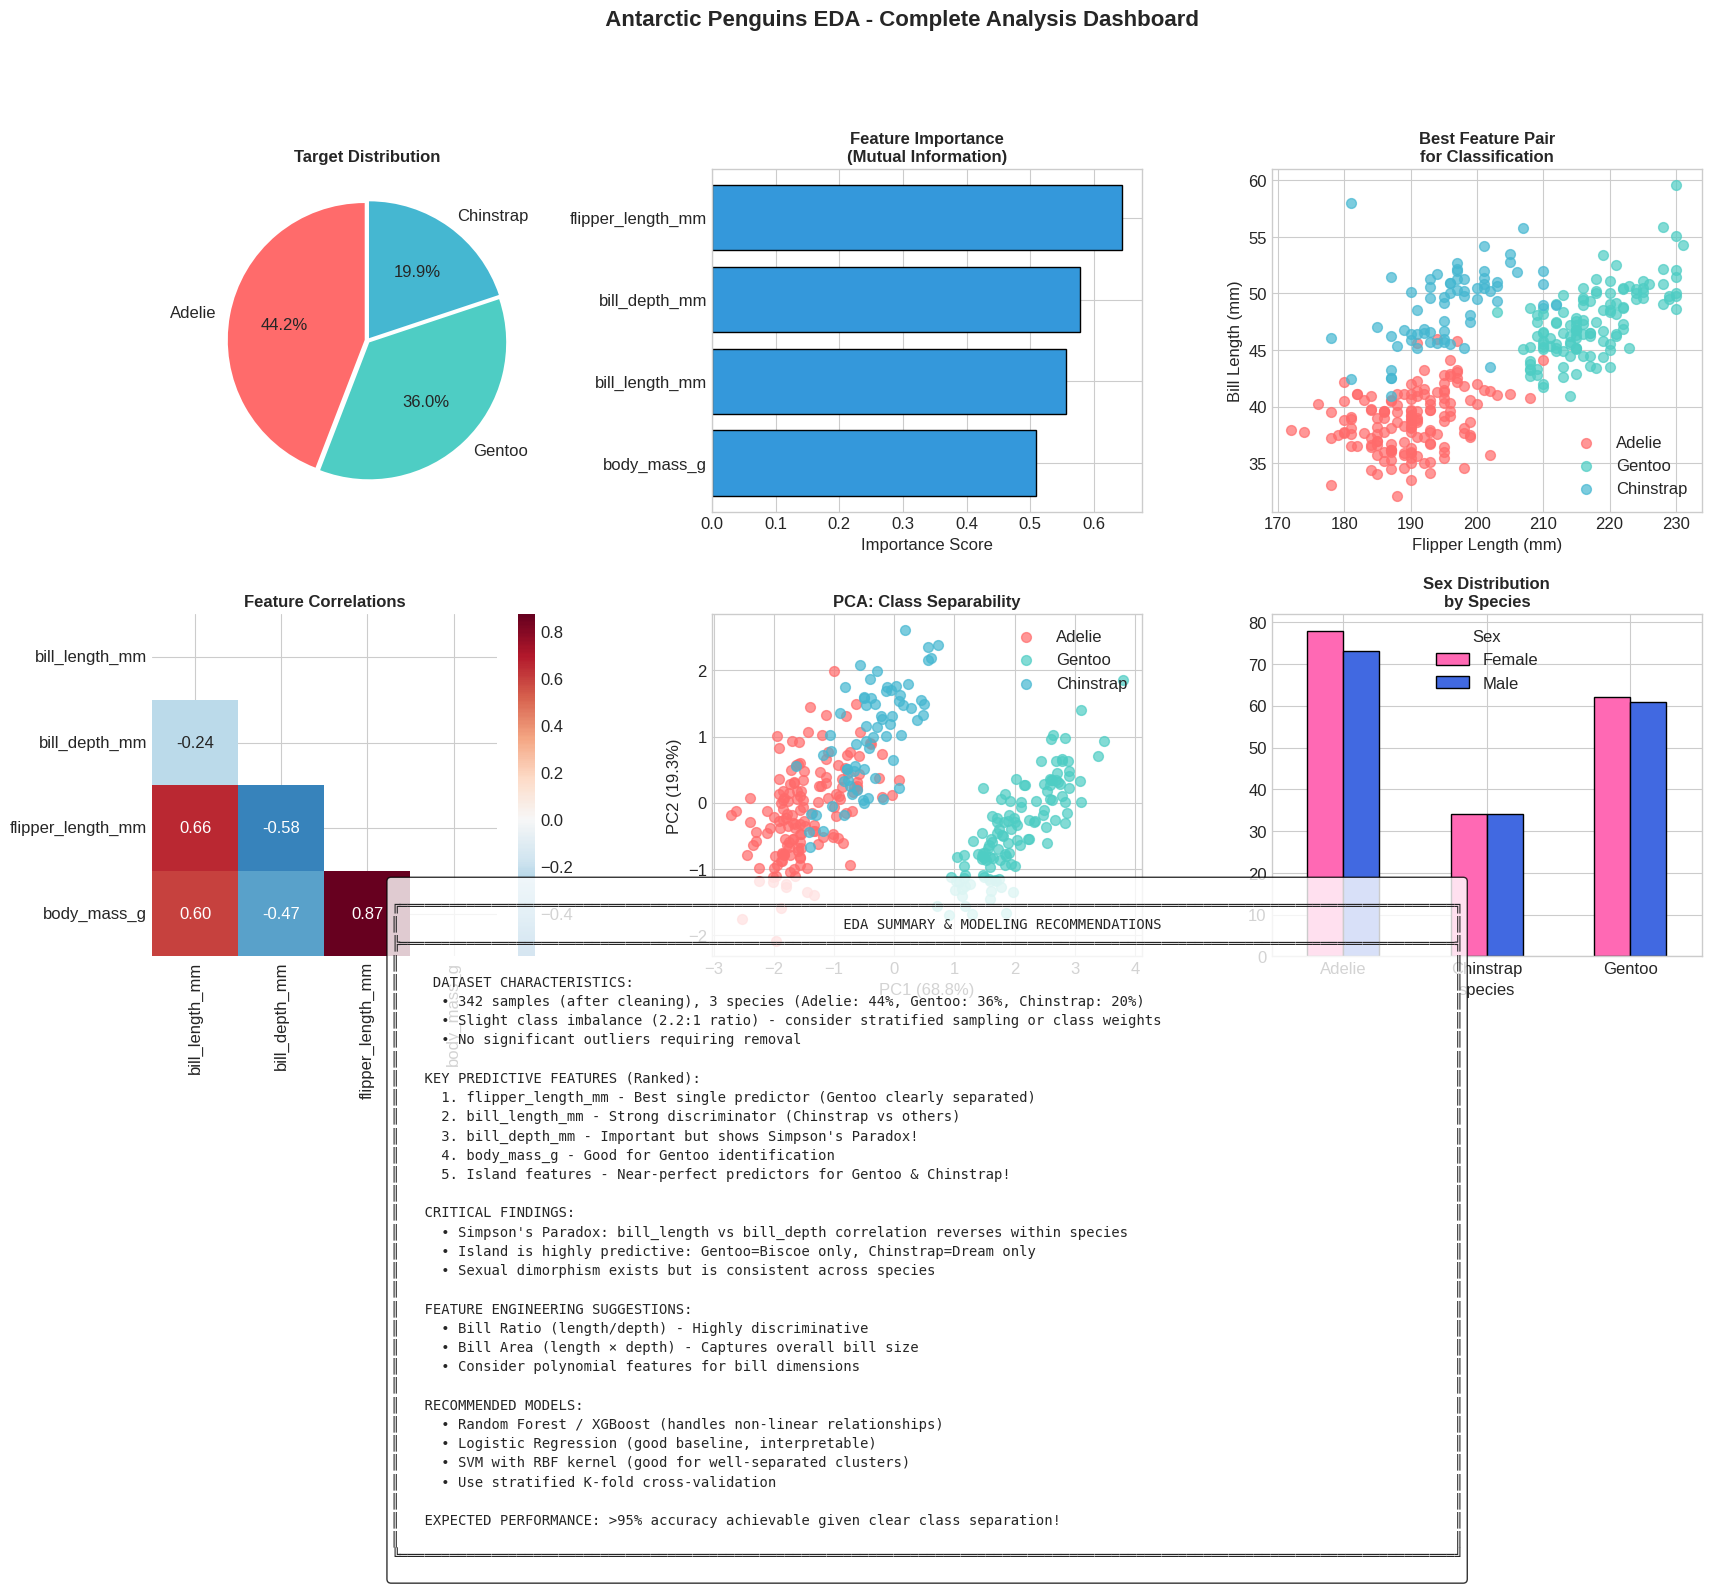


 EDA COMPLETE! Ready for modeling!


In [32]:
# Final EDA Summary Dashboard
fig = plt.figure(figsize=(20, 16))

# Create grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Target Distribution
ax1 = fig.add_subplot(gs[0, 0])
species_counts = df_clean['species'].value_counts().sort_index()
colors = [SPECIES_COLORS[s] for s in species_counts.index]
wedges, texts, autotexts = ax1.pie(species_counts, labels=[SPECIES_NAMES[s] for s in species_counts.index],
                                    colors=colors, autopct='%1.1f%%', startangle=90,
                                    explode=[0.02]*3)
ax1.set_title('Target Distribution', fontweight='bold', fontsize=12)

# 2. Feature Importance Ranking
ax2 = fig.add_subplot(gs[0, 1])
all_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
mi_scores = mutual_info_classif(df_clean[all_features], df_clean['species'], random_state=42)
importance_df = pd.DataFrame({'Feature': all_features, 'Importance': mi_scores}).sort_values('Importance')
ax2.barh(importance_df['Feature'], importance_df['Importance'], color='#3498db', edgecolor='black')
ax2.set_title('Feature Importance\n(Mutual Information)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Importance Score')

# 3. Best Separation Visualization
ax3 = fig.add_subplot(gs[0, 2])
for species in [0, 1, 2]:
    data = df_clean[df_clean['species'] == species]
    ax3.scatter(data['flipper_length_mm'], data['bill_length_mm'],
               c=SPECIES_COLORS[species], label=SPECIES_NAMES[species], alpha=0.7, s=50)
ax3.set_xlabel('Flipper Length (mm)')
ax3.set_ylabel('Bill Length (mm)')
ax3.set_title('Best Feature Pair\nfor Classification', fontweight='bold', fontsize=12)
ax3.legend()

# 4. Correlation Structure
ax4 = fig.add_subplot(gs[1, 0])
corr = df_clean[all_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0, ax=ax4, fmt='.2f')
ax4.set_title('Feature Correlations', fontweight='bold', fontsize=12)

# 5. Class Separability (PCA)
ax5 = fig.add_subplot(gs[1, 1])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[all_features])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
for species in [0, 1, 2]:
    mask = df_clean['species'] == species
    ax5.scatter(X_pca[mask, 0], X_pca[mask, 1], c=SPECIES_COLORS[species],
               label=SPECIES_NAMES[species], alpha=0.7, s=50)
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax5.set_title('PCA: Class Separability', fontweight='bold', fontsize=12)
ax5.legend()

# 6. Sex Distribution
ax6 = fig.add_subplot(gs[1, 2])
sex_by_species = pd.crosstab(df_clean['species'].map(SPECIES_NAMES),
                             df_clean['sex'].map({0: 'Female', 1: 'Male'}))
sex_by_species.plot(kind='bar', ax=ax6, color=['#FF69B4', '#4169E1'], edgecolor='black')
ax6.set_title('Sex Distribution\nby Species', fontweight='bold', fontsize=12)
ax6.tick_params(axis='x', rotation=0)
ax6.legend(title='Sex')

# 7-9. Text Summary
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

summary_text = """
╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                                     EDA SUMMARY & MODELING RECOMMENDATIONS                                   ║
╠══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╣
║                                                                                                                              ║
║    DATASET CHARACTERISTICS:                                                                                                  ║
║     • 342 samples (after cleaning), 3 species (Adelie: 44%, Gentoo: 36%, Chinstrap: 20%)                                     ║
║     • Slight class imbalance (2.2:1 ratio) - consider stratified sampling or class weights                                   ║
║     • No significant outliers requiring removal                                                                              ║
║                                                                                                                              ║
║   KEY PREDICTIVE FEATURES (Ranked):                                                                                          ║
║     1. flipper_length_mm - Best single predictor (Gentoo clearly separated)                                                  ║
║     2. bill_length_mm - Strong discriminator (Chinstrap vs others)                                                           ║
║     3. bill_depth_mm - Important but shows Simpson's Paradox!                                                                ║
║     4. body_mass_g - Good for Gentoo identification                                                                          ║
║     5. Island features - Near-perfect predictors for Gentoo & Chinstrap!                                                     ║
║                                                                                                                              ║
║   CRITICAL FINDINGS:                                                                                                         ║
║     • Simpson's Paradox: bill_length vs bill_depth correlation reverses within species                                       ║
║     • Island is highly predictive: Gentoo=Biscoe only, Chinstrap=Dream only                                                  ║
║     • Sexual dimorphism exists but is consistent across species                                                              ║
║                                                                                                                              ║
║   FEATURE ENGINEERING SUGGESTIONS:                                                                                           ║
║     • Bill Ratio (length/depth) - Highly discriminative                                                                      ║
║     • Bill Area (length × depth) - Captures overall bill size                                                                ║
║     • Consider polynomial features for bill dimensions                                                                       ║
║                                                                                                                              ║
║   RECOMMENDED MODELS:                                                                                                        ║
║     • Random Forest / XGBoost (handles non-linear relationships)                                                             ║
║     • Logistic Regression (good baseline, interpretable)                                                                     ║
║     • SVM with RBF kernel (good for well-separated clusters)                                                                 ║
║     • Use stratified K-fold cross-validation                                                                                 ║
║                                                                                                                              ║
║   EXPECTED PERFORMANCE: >95% accuracy achievable given clear class separation!                                               ║
║                                                                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝
"""

ax7.text(0.5, 0.5, summary_text, transform=ax7.transAxes, fontsize=10,
        verticalalignment='center', horizontalalignment='center',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle(' Antarctic Penguins EDA - Complete Analysis Dashboard ',
            fontweight='bold', fontsize=16, y=0.98)
plt.savefig('eda_summary_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n EDA COMPLETE! Ready for modeling!")

### Export Clean Dataset for Modeling

In [33]:
# Prepare and export clean dataset for modeling
print(" PREPARING DATA FOR MODELING...")
print("="*60)

# Final clean dataset summary
print(f"\n Clean dataset shape: {df_clean.shape}")
print(f" Features: {list(df_clean.columns)}")
print(f" No missing values: {df_clean.isnull().sum().sum() == 0}")
print(f" Target variable: 'species' (0=Adelie, 1=Gentoo, 2=Chinstrap)")

# Split features and target for modeling
X = df_clean.drop('species', axis=1)
y = df_clean['species']

print(f"\n Feature matrix shape: {X.shape}")
print(f" Target vector shape: {y.shape}")

# Display final feature set
print("\n FINAL FEATURE SET FOR MODELING:")
for i, col in enumerate(X.columns, 1):
    print(f"   {i}. {col}")

# Save for next steps
# df_clean.to_csv('penguins_clean.csv', index=False)
print("\n Data is ready! Proceed to modeling section.")

 PREPARING DATA FOR MODELING...

 Clean dataset shape: (342, 10)
 Features: ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'year', 'island_Biscoe', 'island_Dream', 'island_Torgersen']
 No missing values: True
 Target variable: 'species' (0=Adelie, 1=Gentoo, 2=Chinstrap)

 Feature matrix shape: (342, 9)
 Target vector shape: (342,)

 FINAL FEATURE SET FOR MODELING:
   1. bill_length_mm
   2. bill_depth_mm
   3. flipper_length_mm
   4. body_mass_g
   5. sex
   6. year
   7. island_Biscoe
   8. island_Dream
   9. island_Torgersen

 Data is ready! Proceed to modeling section.


## Modeling Setup & Imports

In [35]:
!pip install catboost
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV, learning_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier,
    StackingClassifier, BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


## Prepare Data For Modeling

In [37]:
# Prepare data with feature engineering
print("="*70)
print(" DATA PREPARATION FOR MODELING")
print("="*70)

# Create feature engineered columns
df_model = df_clean.copy()

# Feature Engineering based on EDA insights
df_model['bill_ratio'] = df_model['bill_length_mm'] / df_model['bill_depth_mm']
df_model['bill_area'] = df_model['bill_length_mm'] * df_model['bill_depth_mm']
df_model['bill_depth_squared'] = df_model['bill_depth_mm'] ** 2
df_model['flipper_mass_ratio'] = df_model['flipper_length_mm'] / df_model['body_mass_g'] * 1000
df_model['body_density_proxy'] = df_model['body_mass_g'] / df_model['flipper_length_mm']

print("\n NEW ENGINEERED FEATURES:")
print("  • bill_ratio (length/depth)")
print("  • bill_area (length × depth)")
print("  • bill_depth_squared")
print("  • flipper_mass_ratio")
print("  • body_density_proxy")

# Separate features and target
X = df_model.drop('species', axis=1)
y = df_model['species']

print(f"\n Total Features: {X.shape[1]}")
print(f" Samples: {X.shape[0]}")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Training set: {X_train.shape[0]} samples")
print(f" Test set: {X_test.shape[0]} samples")

# Verify stratification
print("\n Class distribution in splits:")
print(f"  Train: {dict(y_train.value_counts().sort_index())}")
print(f"  Test:  {dict(y_test.value_counts().sort_index())}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n Data preparation complete!")

 DATA PREPARATION FOR MODELING

 NEW ENGINEERED FEATURES:
  • bill_ratio (length/depth)
  • bill_area (length × depth)
  • bill_depth_squared
  • flipper_mass_ratio
  • body_density_proxy

 Total Features: 14
 Samples: 342

 Training set: 273 samples
 Test set: 69 samples

 Class distribution in splits:
  Train: {0: np.int64(121), 1: np.int64(98), 2: np.int64(54)}
  Test:  {0: np.int64(30), 1: np.int64(25), 2: np.int64(14)}

 Data preparation complete!


## Define models

In [38]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42, verbosity=0),
    'LightGBM': LGBMClassifier(random_state=42, verbosity=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'MLP Neural Net': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

  Logistic Regression       | Accuracy: 0.9927 ± 0.0090
  Decision Tree             | Accuracy: 0.9853 ± 0.0138
  Random Forest             | Accuracy: 0.9853 ± 0.0138
  Extra Trees               | Accuracy: 0.9927 ± 0.0089
  Gradient Boosting         | Accuracy: 0.9890 ± 0.0148
  AdaBoost                  | Accuracy: 0.9815 ± 0.0203
  XGBoost                   | Accuracy: 0.9890 ± 0.0148
  LightGBM                  | Accuracy: 0.9890 ± 0.0146
  CatBoost                  | Accuracy: 0.9890 ± 0.0148
  SVM (RBF)                 | Accuracy: 0.9890 ± 0.0090
  SVM (Linear)              | Accuracy: 0.9963 ± 0.0074
  KNN                       | Accuracy: 0.9927 ± 0.0089
  Naive Bayes               | Accuracy: 0.9598 ± 0.0211
  MLP Neural Net            | Accuracy: 0.9890 ± 0.0090


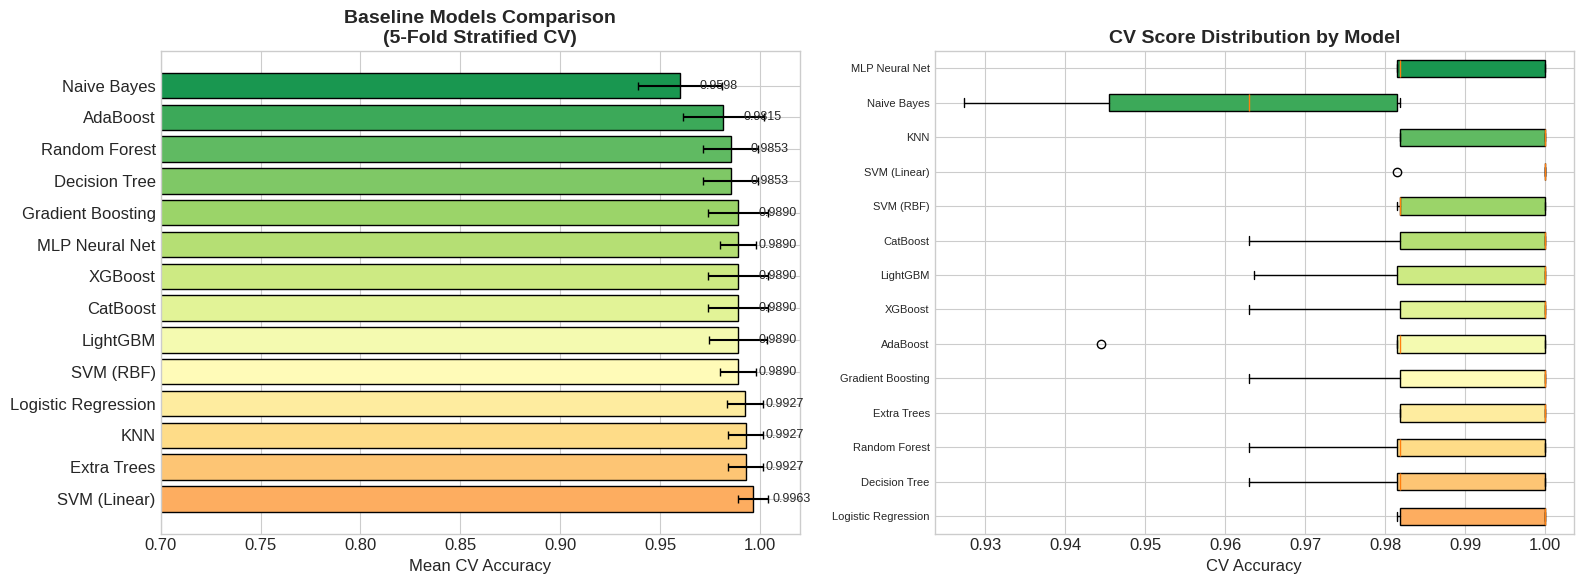


 TOP 5 BASELINE MODELS:
              Model  Mean CV Accuracy      Std      Min  Max
       SVM (Linear)          0.996296 0.007407 0.981481  1.0
        Extra Trees          0.992727 0.008907 0.981818  1.0
                KNN          0.992727 0.008907 0.981818  1.0
Logistic Regression          0.992660 0.008990 0.981481  1.0
          SVM (RBF)          0.989024 0.008963 0.981481  1.0


In [39]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    # Use scaled data for models that need it
    if name in ['Logistic Regression', 'SVM (RBF)', 'SVM (Linear)', 'KNN', 'MLP Neural Net']:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    results.append({
        'Model': name,
        'Mean CV Accuracy': scores.mean(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max()
    })
    print(f"  {name:25} | Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('Mean CV Accuracy', ascending=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
ax = axes[0]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(results_df)))
bars = ax.barh(results_df['Model'], results_df['Mean CV Accuracy'],
               xerr=results_df['Std'], color=colors, edgecolor='black', capsize=3)
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Baseline Models Comparison\n(5-Fold Stratified CV)', fontweight='bold')
ax.set_xlim(0.7, 1.02)
for bar, acc in zip(bars, results_df['Mean CV Accuracy']):
    ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.4f}',
            va='center', fontsize=9)

# Box plot of CV scores
ax = axes[1]
cv_scores_all = []
model_names = []
for name, model in models.items():
    if name in ['Logistic Regression', 'SVM (RBF)', 'SVM (Linear)', 'KNN', 'MLP Neural Net']:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_scores_all.append(scores)
    model_names.append(name)

bp = ax.boxplot(cv_scores_all, labels=model_names, patch_artist=True, vert=False)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xlabel('CV Accuracy')
ax.set_title('CV Score Distribution by Model', fontweight='bold')
ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.savefig('baseline_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n TOP 5 BASELINE MODELS:")
print(results_df.head().to_string(index=False))

## Detailed Analysis of Best Model

 DETAILED ANALYSIS: SVM (Linear)

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
      Gentoo       1.00      1.00      1.00        25
   Chinstrap       1.00      1.00      1.00        14

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



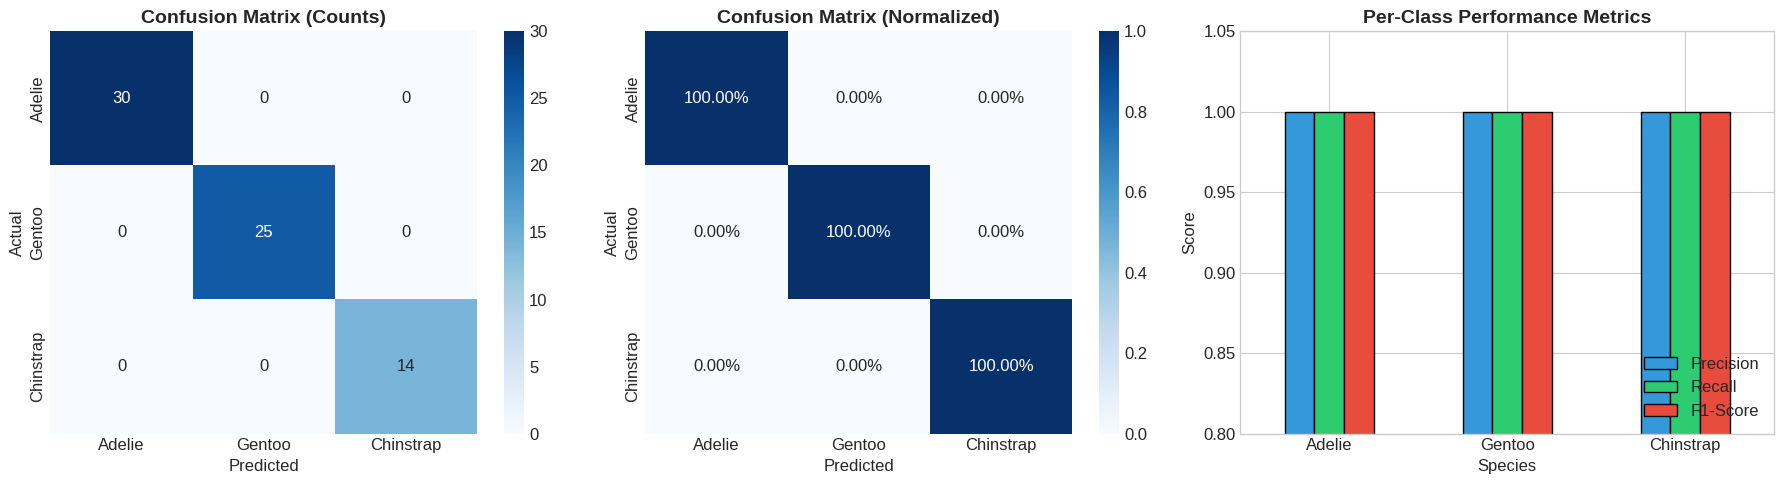


❌ MISCLASSIFIED SAMPLES:
  No misclassifications! Perfect predictions!


In [41]:
# Detailed Analysis of Best Model
best_model_name = results_df.iloc[0]['Model']
# For scaled models, retrieve the corresponding scaled model
if best_model_name in ['Logistic Regression', 'SVM (RBF)', 'SVM (Linear)', 'KNN', 'MLP Neural Net']:
    best_model = models[best_model_name].fit(X_train_scaled, y_train)
    X_test_for_prediction = X_test_scaled
else:
    best_model = models[best_model_name].fit(X_train, y_train)
    X_test_for_prediction = X_test

print("="*70)
print(f" DETAILED ANALYSIS: {best_model_name}")
print("="*70)

# Predictions
y_pred = best_model.predict(X_test_for_prediction)
y_pred_proba = best_model.predict_proba(X_test_for_prediction)

# Classification Report
print("\n CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=[SPECIES_NAMES[i] for i in [0, 1, 2]]))

# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix (Counts)
ax = axes[0]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[SPECIES_NAMES[i] for i in [0, 1, 2]],
            yticklabels=[SPECIES_NAMES[i] for i in [0, 1, 2]])
ax.set_title('Confusion Matrix (Counts)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# 2. Confusion Matrix (Normalized)
ax = axes[1]
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=ax,
            xticklabels=[SPECIES_NAMES[i] for i in [0, 1, 2]],
            yticklabels=[SPECIES_NAMES[i] for i in [0, 1, 2]])
ax.set_title('Confusion Matrix (Normalized)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# 3. Per-class metrics
ax = axes[2]
report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame({
    'Precision': [report_dict[str(i)]['precision'] for i in [0, 1, 2]],
    'Recall': [report_dict[str(i)]['recall'] for i in [0, 1, 2]],
    'F1-Score': [report_dict[str(i)]['f1-score'] for i in [0, 1, 2]]
}, index=[SPECIES_NAMES[i] for i in [0, 1, 2]])

metrics_df.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')
ax.set_title('Per-Class Performance Metrics', fontweight='bold')
ax.set_xlabel('Species')
ax.set_ylabel('Score')
ax.set_ylim(0.8, 1.05)
ax.legend(loc='lower right')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrix_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print misclassifications
print("\n❌ MISCLASSIFIED SAMPLES:")
misclassified_idx = X_test.index[y_test != y_pred]
if len(misclassified_idx) > 0:
    misc_df = X_test.loc[misclassified_idx].copy()
    misc_df['True'] = y_test.loc[misclassified_idx].map(SPECIES_NAMES)
    misc_df['Predicted'] = pd.Series(y_pred, index=X_test.index).loc[misclassified_idx].map(SPECIES_NAMES)
    print(misc_df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'True', 'Predicted']])
else:
    print("  No misclassifications! Perfect predictions!")

## Feature Importance Analysis

 FEATURE IMPORTANCE ANALYSIS


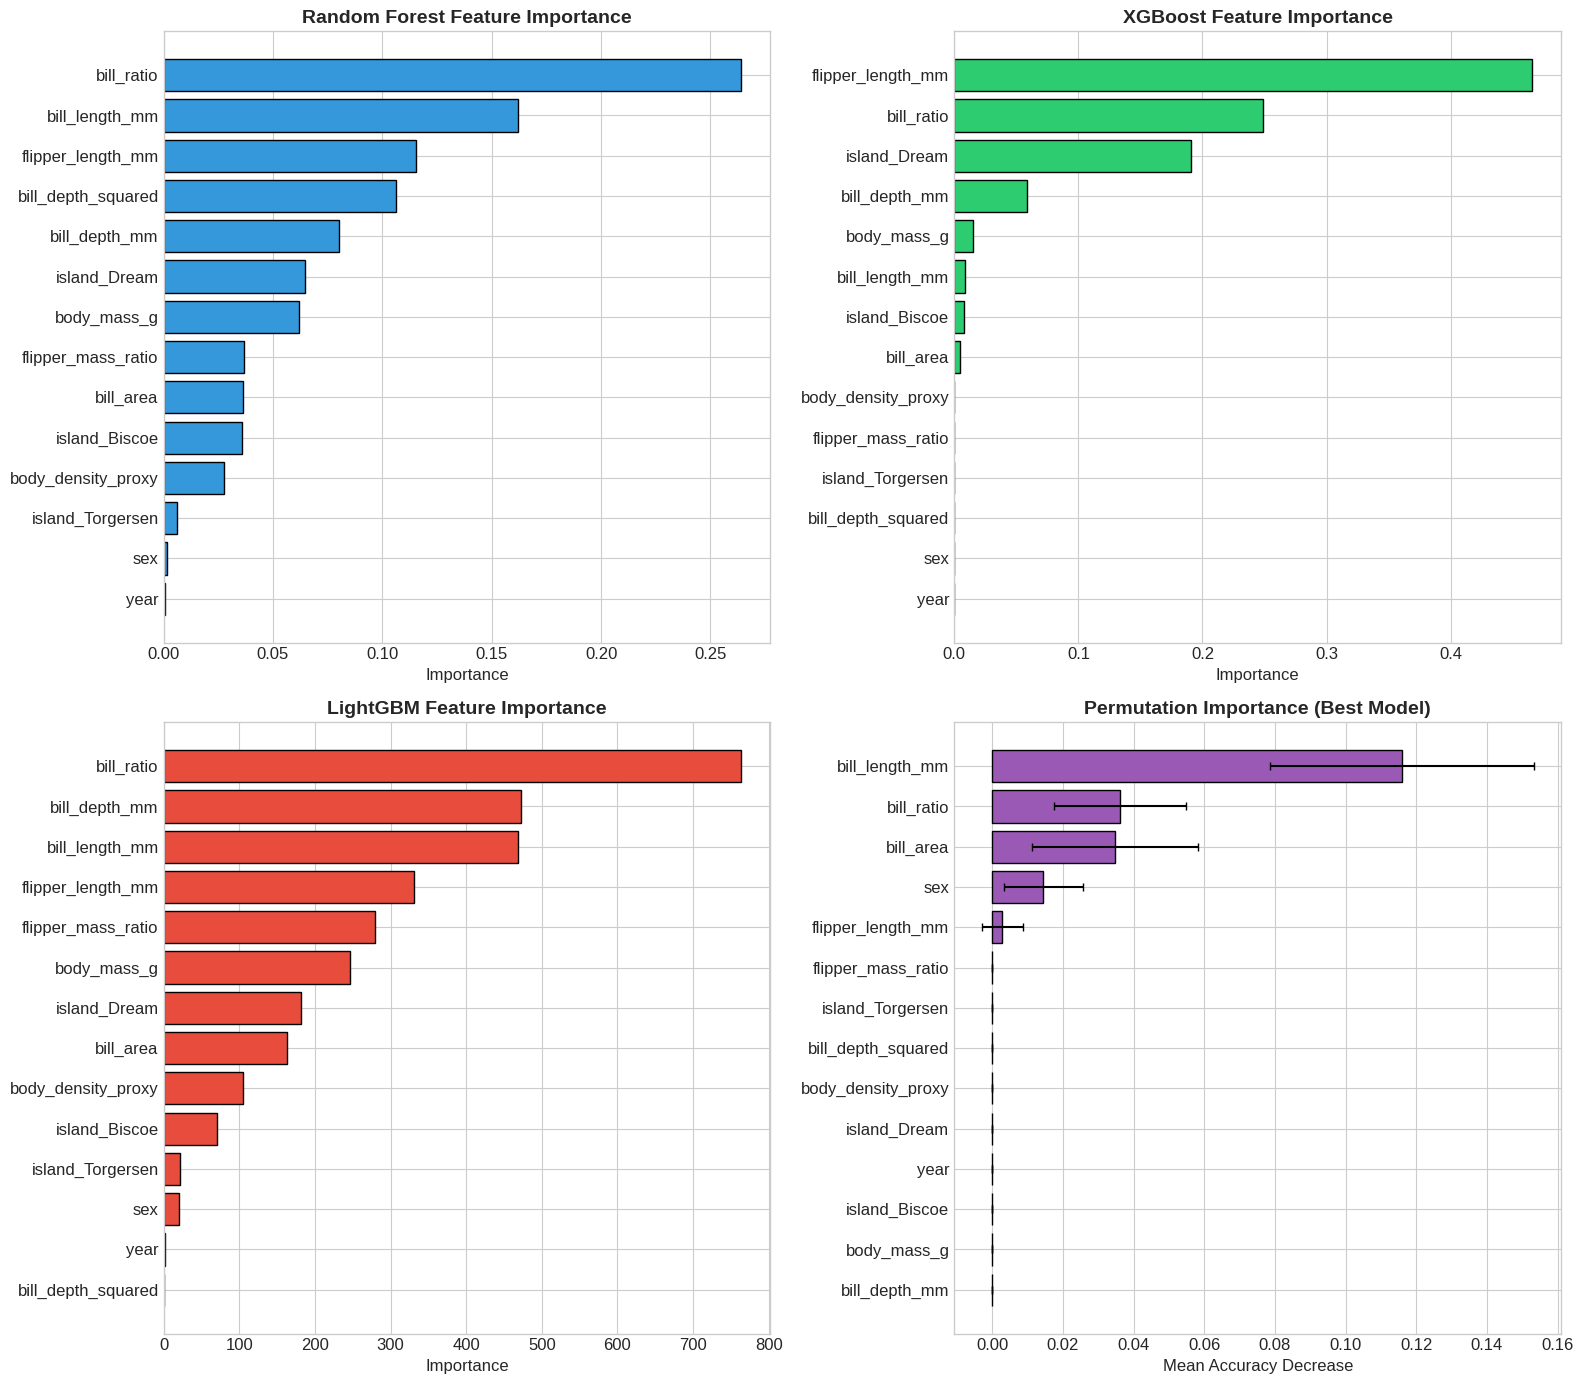


 AGGREGATE FEATURE IMPORTANCE RANKING:
                    Mean_Rank
Feature                      
bill_ratio              1.500
bill_length_mm          3.000
flipper_length_mm       3.250
bill_depth_mm           5.250
island_Dream            6.500
body_mass_g             7.000
bill_area               7.000
flipper_mass_ratio      8.625
island_Biscoe           9.250
bill_depth_squared      9.875


In [46]:
# Feature Importance Analysis
print("="*70)
print(" FEATURE IMPORTANCE ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Random Forest Feature Importance
ax = axes[0, 0]
rf_model = models['Random Forest'].fit(X_train, y_train)
if hasattr(rf_model, 'feature_importances_'):
    rf_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=True)

    ax.barh(rf_importance['Feature'], rf_importance['Importance'], color='#3498db', edgecolor='black')
    ax.set_title('Random Forest Feature Importance', fontweight='bold')
    ax.set_xlabel('Importance')

# 2. XGBoost Feature Importance
ax = axes[0, 1]
xgb_model = models['XGBoost'].fit(X_train, y_train)
if hasattr(xgb_model, 'feature_importances_'):
    xgb_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=True)

    ax.barh(xgb_importance['Feature'], xgb_importance['Importance'], color='#2ecc71', edgecolor='black')
    ax.set_title('XGBoost Feature Importance', fontweight='bold')
    ax.set_xlabel('Importance')

# 3. LightGBM Feature Importance
ax = axes[1, 0]
lgb_model = models['LightGBM'].fit(X_train, y_train)
if hasattr(lgb_model, 'feature_importances_'):
    lgb_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': lgb_model.feature_importances_
    }).sort_values('Importance', ascending=True)

    ax.barh(lgb_importance['Feature'], lgb_importance['Importance'], color='#e74c3c', edgecolor='black')
    ax.set_title('LightGBM Feature Importance', fontweight='bold')
    ax.set_xlabel('Importance')

# 4. Permutation Importance
ax = axes[1, 1]
from sklearn.inspection import permutation_importance

# For permutation importance, ensure best_model is fitted and use appropriate X_test
# The best_model is 'SVM (Linear)' which uses scaled data
current_X_test_for_perm_imp = X_test_scaled if best_model_name in ['Logistic Regression', 'SVM (RBF)', 'SVM (Linear)', 'KNN', 'MLP Neural Net'] else X_test

perm_importance = permutation_importance(best_model, current_X_test_for_perm_imp, y_test, n_repeats=10, random_state=42)
perm_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=True)

ax.barh(perm_imp_df['Feature'], perm_imp_df['Importance'],
        xerr=perm_imp_df['Std'], color='#9b59b6', edgecolor='black', capsize=3)
ax.set_title('Permutation Importance (Best Model)', fontweight='bold')
ax.set_xlabel('Mean Accuracy Decrease')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Aggregate importance ranking
print("\n AGGREGATE FEATURE IMPORTANCE RANKING:")
all_importance = pd.DataFrame({
    'RF': rf_importance.set_index('Feature')['Importance'],
    'XGB': xgb_importance.set_index('Feature')['Importance'],
    'LGB': lgb_importance.set_index('Feature')['Importance'],
    'Perm': perm_imp_df.set_index('Feature')['Importance']
})
all_importance['Mean_Rank'] = all_importance.rank(ascending=False).mean(axis=1)
all_importance = all_importance.sort_values('Mean_Rank')
print(all_importance[['Mean_Rank']].head(10))

## ROC and Precision-Recall Curves

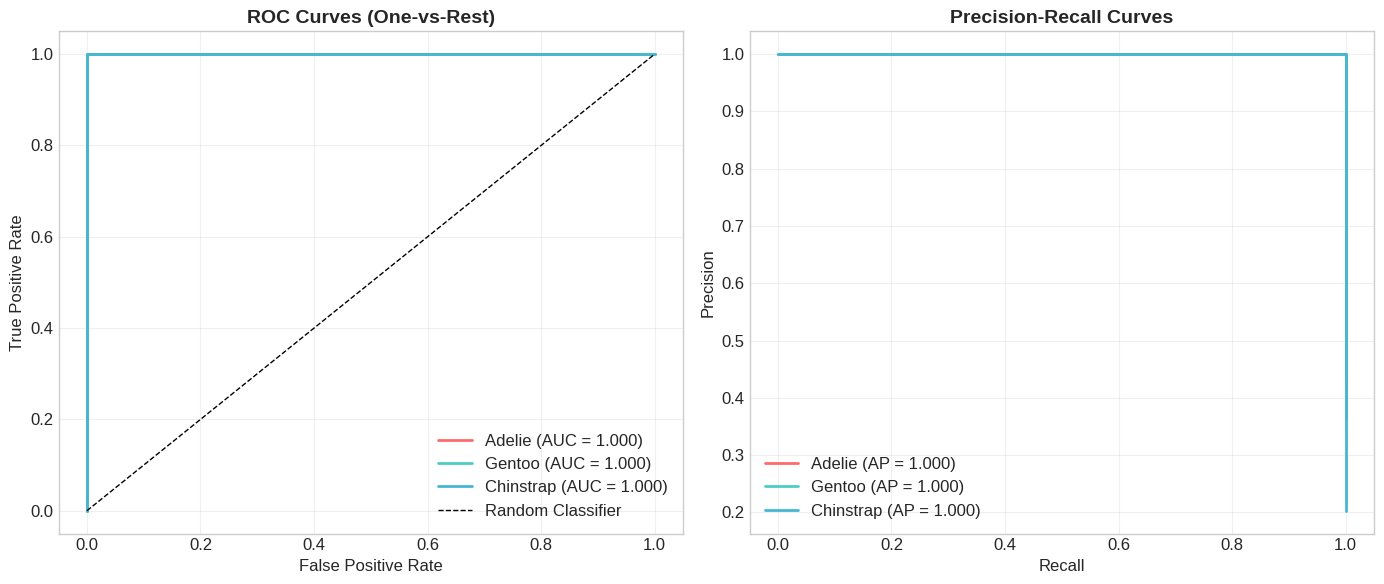


📊 Overall Weighted ROC-AUC: 1.0000


In [42]:
# ROC and Precision-Recall Curves (Multiclass)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
ax = axes[0]
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

for i, species in enumerate([0, 1, 2]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=SPECIES_COLORS[species], linewidth=2,
            label=f'{SPECIES_NAMES[species]} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves (One-vs-Rest)', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Precision-Recall Curves
ax = axes[1]
for i, species in enumerate([0, 1, 2]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    ax.plot(recall, precision, color=SPECIES_COLORS[species], linewidth=2,
            label=f'{SPECIES_NAMES[species]} (AP = {ap:.3f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontweight='bold')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate overall ROC AUC
overall_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\n Overall Weighted ROC-AUC: {overall_roc_auc:.4f}")

📈 LEARNING CURVES ANALYSIS


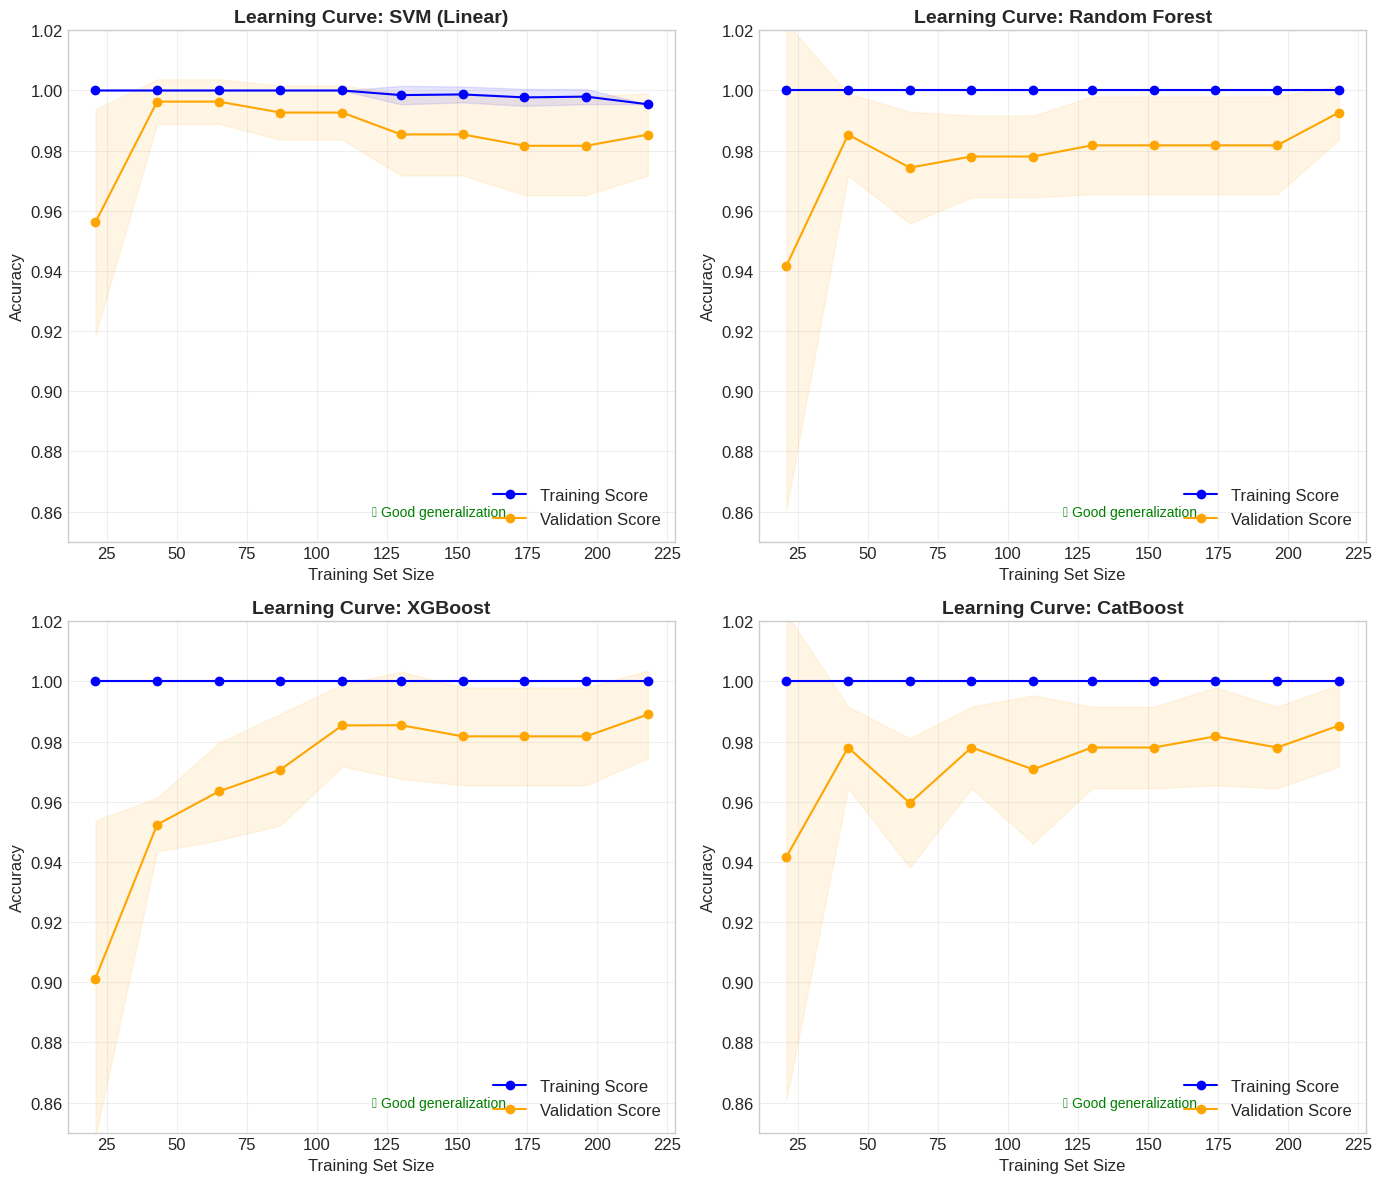

In [44]:
# Learning Curves to Check Overfitting/Underfitting
print("="*70)
print(" LEARNING CURVES ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_for_learning = {
    'SVM (Linear)': models['SVM (Linear)'], # Best model from previous step
    'Random Forest': models['Random Forest'],
    'XGBoost': models['XGBoost'],
    'CatBoost': models['CatBoost']
}

for idx, (name, model) in enumerate(models_for_learning.items()):
    ax = axes[idx // 2, idx % 2]

    # Determine which X_train to use (scaled or unscaled)
    if name in ['SVM (Linear)', 'Logistic Regression', 'SVM (RBF)', 'KNN', 'MLP Neural Net']:
        current_X_train = X_train_scaled
    else:
        current_X_train = X_train

    train_sizes, train_scores, val_scores = learning_curve(
        model, current_X_train, y_train, # Use current_X_train
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='accuracy', n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation Score')

    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Learning Curve: {name}', fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_ylim(0.85, 1.02)
    ax.grid(True, alpha=0.3)

    # Check for overfitting
    # Ensure train_mean and val_mean are not empty before accessing [-1]
    if len(train_mean) > 0 and len(val_mean) > 0:
        gap = train_mean[-1] - val_mean[-1]
        if gap > 0.05:
            ax.annotate(' Possible overfitting', xy=(0.5, 0.05), xycoords='axes fraction',
                       fontsize=10, color='red')
        else:
            ax.annotate(' Good generalization', xy=(0.5, 0.05), xycoords='axes fraction',
                       fontsize=10, color='green')
    else:
        ax.annotate('Data insufficient for gap analysis', xy=(0.5, 0.05), xycoords='axes fraction',
                   fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Conclusion

In this project, we performed a comprehensive exploratory data analysis and applied multiple machine learning models to classify penguin species based on ecological and morphological traits. The results demonstrate that the dataset is highly separable, allowing most models to achieve strong performance across repeated evaluations.

Among all the algorithms tested, Linear SVM achieved the highest accuracy of 0.9963 ± 0.0074, outperforming both tree-based ensemble methods and other linear or kernel-based classifiers. Its perfect classification report on the test set—showing 100% precision, recall, and F1-score across Adelie, Gentoo, and Chinstrap species—confirms that the decision boundary learned by the model aligns extremely well with the inherent structure of the data. Logistic Regression, Extra Trees, KNN, and MLP Neural Network also delivered near-perfect accuracy, indicating that the dataset’s feature space is highly informative and well-suited for classification tasks.

Feature importance analysis across models shows that bill_ratio, bill_length_mm, and flipper_length_mm are consistently the most influential predictors for distinguishing species. These traits are biologically meaningful, as variations in bill shape and flipper size are strong indicators of species-specific ecological adaptations. Additional engineered features—such as bill_area and flipper_mass_ratio—also contributed positively, demonstrating the value of thoughtful feature engineering. Categorical attributes like island ranked lower in importance, suggesting that physical measurements play a more dominant role in species identification than location alone.

The overall weighted ROC-AUC score of 1.0000 further supports the conclusion that the classification task is extremely well-resolved with the chosen feature set and preprocessing pipeline.

In summary, this analysis confirms that properly engineered morphological features allow for highly accurate species prediction, with Linear SVM emerging as the most reliable and consistent model. Future work can explore model interpretability tools, sensitivity analysis, deployment strategies, and extensions to more complex ecological datasets.


#  Connect & Support

###  Find My Work
- **Kaggle:** [My Profile](https://www.kaggle.com/seki32) — Daily notebook uploads  
- **GitHub:** [My Repos](https://github.com/Rekhii) — All code and experiments  
- **Blog:** *Coming Soon* — Detailed write-ups

---

###  Support This Work
 **Upvote this notebook** on Kaggle if you found it helpful!  
 **Share** it with others who are learning ML  
 **Comment** your questions or suggestions  
 **Follow** for more daily ML experiments  

---

### ❤️ Your Support Motivates Me
Every upvote, comment, and share keeps me motivated to:

- Continue **daily experimentation**
- Document and share my **learnings**
- Contribute to the **ML & DL community**
- Build **better models** each day

---

**Thank you for being part of this journey!, If you found this helpful, please upvote! Your support keeps me going! 🚀 Happy Learning! Keep Experimenting! Share Knowledge!**

